## Final Project Submission - Phase 2

* Student name: Magali Solimano
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Claude Fried
* Blog post URL: https://dev.to/magali/making-use-of-zip-codes-1nep


### Goal of analysis: 

To inform King County, WA single-family home owners of features that affect housing prices.The county has commissioned analysis of its house sales to assist home buyers and sellers to make informed decision-making in the residential real estate market. The analysis will be publicly available for all county residents.

In [200]:
# Import libraries and functions
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import dataset for King County House Sales
df = pd.read_csv('data/kc_house_data.csv')

# Column names and descriptions for King County Data Set
* **id** - unique identified for a house
* **date** - house was sold
* **price** -  prediction target
* **bedrooms** -  number of Bedrooms/House
* **bathrooms** -  number of bathrooms/bedrooms
* **sqft_living** - square footage of the home
* **sqft_lot** - square footage of the lot
* **floors** -  total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is (Overall)
* **grade** - overall grade given to the housing unit, based on King County grading system. Classification by construction quality which refers to the types of materials used and the quality of workmanship.
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

# Understanding the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
df.duplicated().value_counts()

False    21597
dtype: int64

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


- Three variables have missing values: waterfront, view, yr_renovated.
- Some variables will require changing dtype classifications: date, sqft_basement.
- There are no duplicate entries.

In [6]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


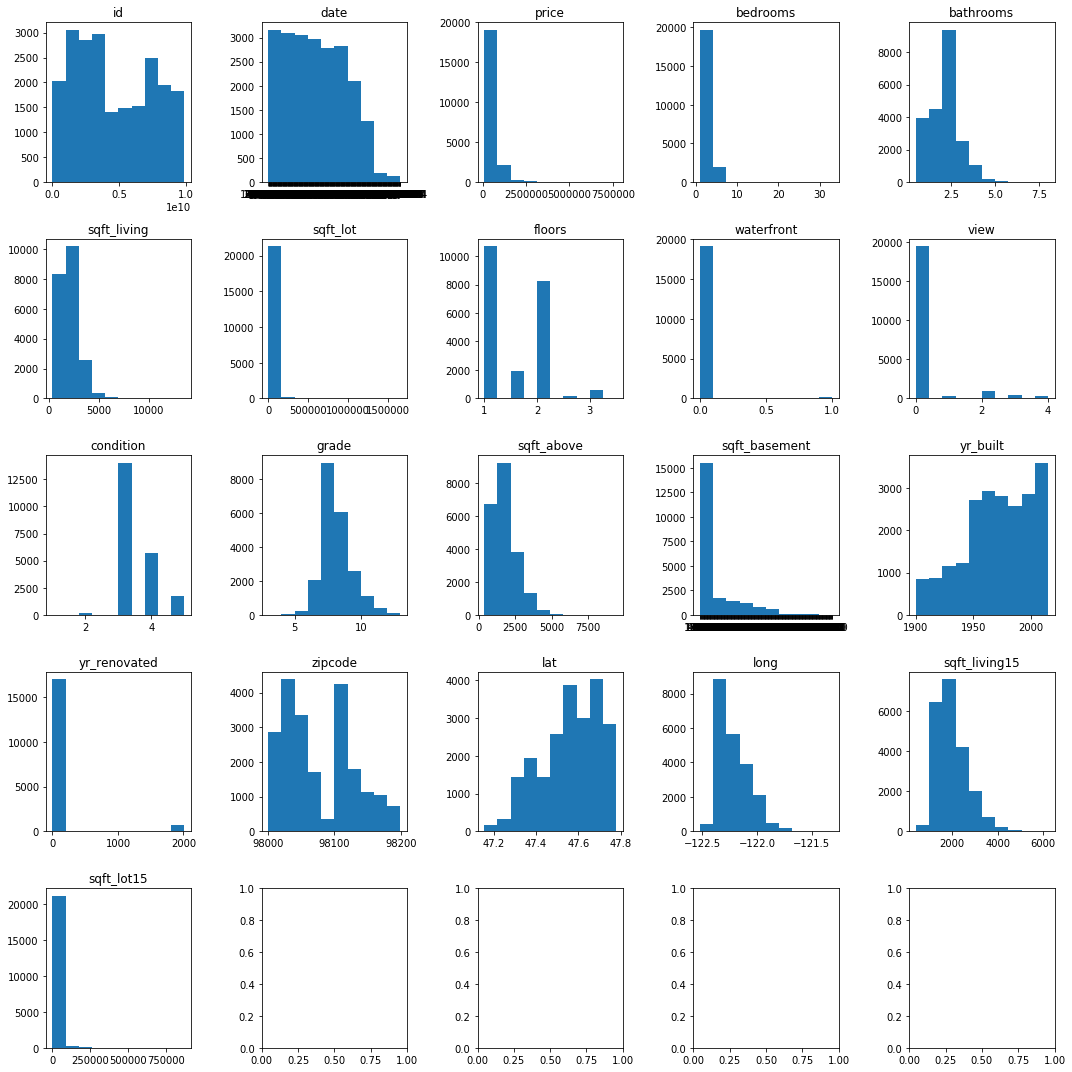

In [7]:
# Examine distributions to better understand data and what preparation the data may need

fig, axes = plt.subplots(5,5, figsize=(15,15))
fig.set_tight_layout(True)

for index, col in enumerate(df.columns):
    ax = axes[index//5][index%5]
    ax.hist(df[col])
    #ax.set_xlabel(col)
    
    ax.set_title(col)
    
fig.tight_layout()   

- Data for dependent variable (price) and many independent variables (bedrooms, bathrooms, sqft_living, sqft_lot, other sqft variables) are highly skewed, with large outliers. Many variables are positively skewed, with large outliers in right tail. Since this analysis is focused on prices for single-family homes, outlier analysis will start with removing outliers for price, number of bedrooms, and number of bathrooms that exceed what would be expected to seen for single-family homes in a normal distribution.
- Additional data could be extracted from date, such as quarter sold, month sold, day sold.
- There appear to be categorical variables (waterfront) and other variables (eg, zipcode, year renovated) can perhaps be treated as categorical as well.
- id variable may not be useful feature for this home price analysis, but could shed light on records in the datasets.

In [8]:
# Do some home ids appear more than once in the dataset?
df.id.value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

In [9]:
display(df.groupby('id')['id', 'date', 'price'].filter(lambda x: len(x) > 1).nunique())
df.groupby('id')['id', 'date', 'price'].filter(lambda x: len(x) > 1)

id       176
date     186
price    250
dtype: int64

,id,date,price
93,6021501535,7/25/2014,430000.0
94,6021501535,12/23/2014,700000.0
313,4139480200,6/18/2014,1380000.0
314,4139480200,12/9/2014,1400000.0
324,7520000520,9/5/2014,232000.0
...,...,...,...
20654,8564860270,3/30/2015,502000.0
20763,6300000226,6/26/2014,240000.0
20764,6300000226,5/4/2015,380000.0
21564,7853420110,10/3/2014,594866.0


- 176 homes sold more than once, and this accounts for a small share of the dataset (0.8%). Some homes may have been flipped, or deals may have fallen through.

## Data preparation

In [10]:
# DATA TYPE CONVERSIONS
# Convert date to date dtype
df_pp = df  #df for preprocessing of data
df_pp.date = pd.to_datetime(df['date'])
df_pp.date

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21592   2014-05-21
21593   2015-02-23
21594   2014-06-23
21595   2015-01-16
21596   2014-10-15
Name: date, Length: 21597, dtype: datetime64[ns]

In [11]:
# Extract year, quarter, month, day, day of week from date
df_pp['yr_sold'] = pd.DatetimeIndex(df.date).year
df_pp['quarter_sold'] = pd.DatetimeIndex(df.date).quarter
df_pp['month_sold'] = pd.DatetimeIndex(df.date).month
df_pp['day_of_week_sold'] = pd.DatetimeIndex(df.date).dayofweek  #legend: 0-Monday, 6-Sunday

In [12]:
# Convert sqft_basement dtype from object to float
df_pp.sqft_basement.value_counts(dropna=False)

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
176.0         1
2120.0        1
3480.0        1
2400.0        1
1930.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [13]:
# '?' value is probably a NaN, which we can replace with NaN and then replace with the mean
df_pp.sqft_basement = df.sqft_basement.replace('?', np.nan)

# Convert sqft_basement data type to float. 
df_pp['sqft_basement'] = df['sqft_basement'].astype(float)

# Replace NaN with mean values.
df_pp.sqft_basement = df.sqft_basement.fillna(df.sqft_basement.mean())
df_pp.sqft_basement.value_counts(dropna=False)

0.000000       12826
291.851724       454
600.000000       217
500.000000       209
700.000000       208
               ...  
588.000000         1
1920.000000        1
2390.000000        1
1245.000000        1
1135.000000        1
Name: sqft_basement, Length: 304, dtype: int64

In [14]:
# MISSING VALUES: Check for missing values in target variable (price) and dependent variables
df_pp.isna().sum()

id                     0
date                   0
price                  0
bedrooms               0
bathrooms              0
sqft_living            0
sqft_lot               0
floors                 0
waterfront          2376
view                  63
condition              0
grade                  0
sqft_above             0
sqft_basement          0
yr_built               0
yr_renovated        3842
zipcode                0
lat                    0
long                   0
sqft_living15          0
sqft_lot15             0
yr_sold                0
quarter_sold           0
month_sold             0
day_of_week_sold       0
dtype: int64

In [15]:
df_pp.waterfront.value_counts(dropna=False, normalize = True)

0.0    0.883225
NaN    0.110015
1.0    0.006760
Name: waterfront, dtype: float64

- Very few homes have waterfront views. 11% of waterfront values are null, which is somewhat high but there is comfort making an assumption that NaN value means there is no waterfront view given that this matches the most common value.

In [16]:
# waterfront variable: replace "NaN" with mode
df_pp.waterfront = df.waterfront.fillna(df.waterfront.mode()[0])

# check new value counts
df_pp.waterfront.value_counts(dropna=False, normalize = True)

0.0    0.99324
1.0    0.00676
Name: waterfront, dtype: float64

In [17]:
df_pp.view.value_counts(dropna=False, normalize=True)

0.0    0.899292
2.0    0.044312
3.0    0.023522
1.0    0.015280
4.0    0.014678
NaN    0.002917
Name: view, dtype: float64

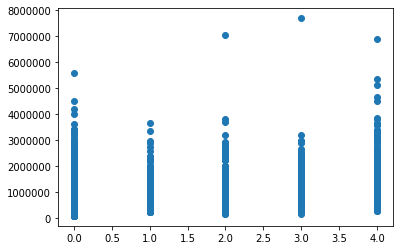

In [18]:
plt.scatter(df_pp.view,df_pp.price)

In [19]:
# view variable: fill NaN with the mean value. Round value since number of views should be whole integers.
df_pp.view = df.view.fillna(df.view.mean().round())
df_pp.view.value_counts(dropna=False)

0.0    19485
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [20]:
df_pp.yr_renovated.value_counts(dropna=False, normalize=True)

0.0       0.787656
NaN       0.177895
2014.0    0.003380
2003.0    0.001435
2013.0    0.001435
            ...   
1944.0    0.000046
1948.0    0.000046
1976.0    0.000046
1934.0    0.000046
1953.0    0.000046
Name: yr_renovated, Length: 71, dtype: float64

- The majority of homes have not been renovated. This variable presents data challenges: There are few data points for most years, and 18% of values are NaN, which is high. NaN is assumed to mean that the home was not renovated.

In [21]:
# Replace yr_renovated null values with 0.
df_pp.yr_renovated = df.yr_renovated.fillna(0)
df_pp.yr_renovated.value_counts(dropna=False, normalize=True)

0.0       0.965551
2014.0    0.003380
2003.0    0.001435
2013.0    0.001435
2007.0    0.001389
            ...   
1946.0    0.000046
1959.0    0.000046
1971.0    0.000046
1951.0    0.000046
1954.0    0.000046
Name: yr_renovated, Length: 70, dtype: float64

In [22]:
#Is bathrooms variable really bathrooms/bedrooms? or just bathrooms/house?
df_pp.bathrooms.nunique()

29

In [23]:
df_pp.bathrooms.value_counts(ascending=False)

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [24]:
bath_test = df.bathrooms * df.bedrooms
bath_test.value_counts(ascending=False)

10.00    2612
7.50     2405
3.00     2076
5.25     1870
2.00     1565
         ... 
26.00       1
52.50       1
33.75       1
23.00       1
57.75       1
Length: 91, dtype: int64

- Given the values in the bathrooms variable, which are high, it is unlikely that this variable captures the number of bathrooms to bedrooms. It is more likely that this variable captures the number of bathrooms per home.

# Outlier Analysis

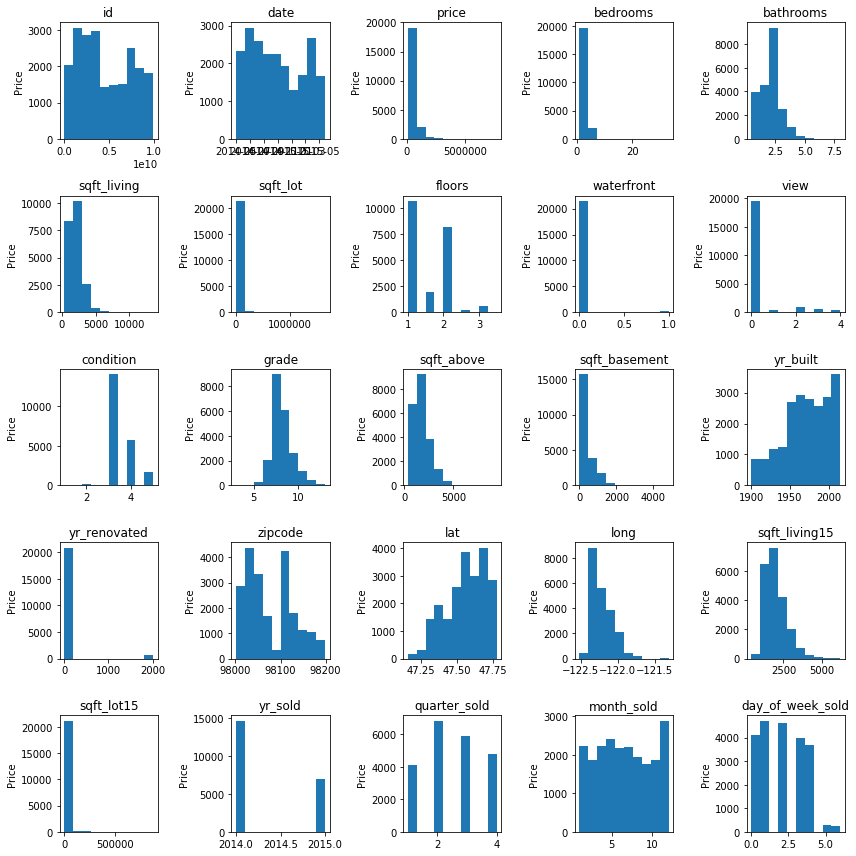

In [25]:
# Plot distributions vs dependent variable (price)
fig, axes = plt.subplots(5,5, figsize=(12,12))
fig.set_tight_layout(True)

for index, col in enumerate(df_pp.columns):
    ax = axes[index//5][index%5]
    ax.hist(df_pp[col])
    #ax.set_xlabel(col)
    ax.set_ylabel('Price')
    
    ax.set_title(col)
    
fig.tight_layout()   

In [26]:
# Explore distribution of price
df_pp.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

Text(0.5, 1.0, 'Distribution of Price')

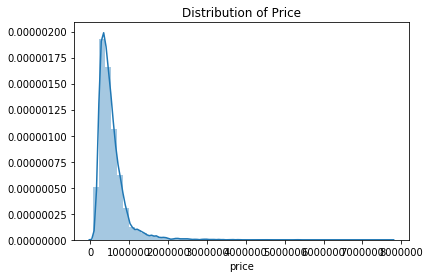

In [27]:
sns.distplot(df_pp.price)
plt.title('Distribution of Price')

In [28]:
display(df_pp.price.quantile([0.50, 0.068, 0.95, 0.997]))

0.500     450000.0
0.068     225000.0
0.950    1160000.0
0.997    2882120.0
Name: price, dtype: float64

- As noted previously, price is positively skewed, with large outliers in the right tail. Remove price outliers. Criteria: remove outliers that are not consistent with focus on single-family home prices (eg, outliers are those that are more than 3 std above mean in normal distribution).

In [29]:
# Set max price threshold at mean + three standard deviations (as would be found in normally distributed data).
df_pp[(np.abs(stats.zscore(df.price)) < 3)].describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,quarter_sold,month_sold,day_of_week_sold
count,2.119100e+04,2.119100e+04,21191.000000,21191.000000,21191.000000,2.119100e+04,21191.000000,21191.000000,21191.000000,21191.000000,...,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000
mean,4.592327e+09,5.070103e+05,3.356095,2.087514,2032.486103,1.482673e+04,1.486858,0.003775,0.204757,3.408051,...,65.267189,98078.289651,47.558989,-122.213732,1960.388656,12631.720589,2014.322543,2.525931,6.577651,2.010665
std,2.878225e+09,2.594622e+05,0.917527,0.736021,836.738586,4.040095e+04,0.538297,0.061328,0.706625,0.648903,...,354.983824,53.407481,0.139455,0.141433,655.151335,27193.757002,0.467460,1.033865,3.114414,1.461502
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,...,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,1.000000,1.000000,0.000000
25%,2.125400e+09,3.200000e+05,3.000000,1.500000,1410.000000,5.005500e+03,1.000000,0.000000,0.000000,3.000000,...,0.000000,98033.000000,47.467050,-122.329000,1480.000000,5080.000000,2014.000000,2.000000,4.000000,1.000000
50%,3.905040e+09,4.470000e+05,3.000000,2.250000,1890.000000,7.560000e+03,1.000000,0.000000,0.000000,3.000000,...,0.000000,98065.000000,47.569900,-122.231000,1820.000000,7576.000000,2014.000000,2.000000,6.000000,2.000000
75%,7.334500e+09,6.276500e+05,4.000000,2.500000,2500.000000,1.049050e+04,2.000000,0.000000,0.000000,4.000000,...,0.000000,98118.000000,47.678800,-122.124000,2330.000000,10000.000000,2015.000000,3.000000,9.000000,3.000000
max,9.900000e+09,1.640000e+06,33.000000,7.500000,7480.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,871200.000000,2015.000000,4.000000,12.000000,6.000000


- Price max is reduced from $7.7 M to $1.6 M.

In [30]:
df_pp[(np.abs(stats.zscore(df.price)) < 3)].shape

(21191, 25)

In [31]:
# How much data would be dropped if this max price threshold is applied?
print('No. rows dropped due to setting max price threshold:', (21597-21191))
print('Percent of original dataset dropped due to setting max price threshold:', (100*round(((21597-21191)/21597),3)), '%')

No. rows dropped due to setting max price threshold: 406
Percent of original dataset dropped due to setting max price threshold: 1.9 %


In [32]:
df_pp = df_pp[(np.abs(stats.zscore(df.price)) < 3)]

In [33]:
# Remove outliers for bedrooms and bathrooms in accordance with goal of focusing on single-family homes..

3     9757
4     6686
2     2756
5     1492
6      252
1      196
7       32
8        9
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

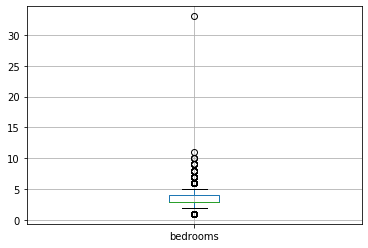

In [34]:
# Address outliers for bedrooms
display(df_pp.bedrooms.value_counts())
df_pp.boxplot(column = 'bedrooms')

- Bedrooms variable has large outlier, '33'. Assume original entry was typo. 

In [35]:
# Replace '33' outlier with mean value.
df_pp.bedrooms.mean().round(0)  #round mean to whole number since 3.3 bedrooms would not be realistic.

3.0

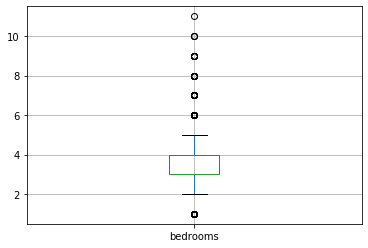

In [36]:
df_pp.bedrooms = df_pp.bedrooms.replace([33],3)
df_pp.boxplot(column = 'bedrooms')

- Even when the '33' outlier is excluded, remaining bedroom outliers are still too large for single-family home sale analysis.

In [37]:
# Set maximum number of bedrooms to mean + three std (as would be found for 99.7% of data in a normal distribution)
# Number of rows that would be dropped by applying max bedrooms threshold
df_pp[(np.abs(stats.zscore(df_pp.bedrooms)) < 3)].shape

(21140, 25)

In [38]:
# How much data would be dropped if this max bedroom threshold is applied?
print('No. rows dropped due to setting max bedroom threshold:', (21191-21140))
print('Percent of original dataset dropped due to setting max price threshold:', (100*round(((21191-21140)/21597),3)), '%')

No. rows dropped due to setting max bedroom threshold: 51
Percent of original dataset dropped due to setting max price threshold: 0.2 %


In [39]:
# Number of rows that would be dropped by applying max bathrooms threshold
df_pp[(np.abs(stats.zscore(df_pp.bathrooms)) < 3)].shape

(21081, 25)

In [40]:
df_pp[(np.abs(stats.zscore(df_pp.bedrooms)) < 3) & (np.abs(stats.zscore(df_pp.bathrooms)) < 3)].shape

(21041, 25)

In [41]:
# How much data would be dropped if max bedroom and bathroom thresholds are applied (accounting for overlap)?
print('No. rows dropped due to setting max bedroom and bathroom thresholds:', (21191-21041))
print('Percent of original dataset dropped due to setting max price threshold:', (100*round(((21191-21041)/21597),4)), '%')

No. rows dropped due to setting max bedroom and bathroom thresholds: 150
Percent of original dataset dropped due to setting max price threshold: 0.69 %


In [42]:
# Set max bedroom and bathroom thresholds in df
df_pp = df_pp[(np.abs(stats.zscore(df_pp.bedrooms)) < 3) & 
              (np.abs(stats.zscore(df_pp.bathrooms)) < 3)]

In [43]:
df_pp.shape

(21041, 25)

In [44]:
# Recap of impact of outlier removal on dataset
print('How much data is lost by setting max thresholds for price, bedrooms, and bathrooms\nin accordance with focus on single-family homes?')
print('--------------------------------------------------------------------------------------------')
print('Total rows dropped due to new max thresholds for bedrooms and bathrooms (accounting for overlap):',21191 - 21041)
print('Percentage of original dataset:',(100*round(((21191 - 21041)/21597),4)),'%')

print('Total rows dropped due to new max thresholds for price, bedrooms, and bathrooms:', 21597 - 21041)
print('Percentage of original dataset:',(100*round(((21597 - 21041)/21597),3)),'%')

How much data is lost by setting max thresholds for price, bedrooms, and bathrooms
in accordance with focus on single-family homes?
--------------------------------------------------------------------------------------------
Total rows dropped due to new max thresholds for bedrooms and bathrooms (accounting for overlap): 150
Percentage of original dataset: 0.69 %
Total rows dropped due to new max thresholds for price, bedrooms, and bathrooms: 556
Percentage of original dataset: 2.6 %


- Removing outliers for price, bedrooms, and bathrooms that were higher than 3 std from the mean results in dropping 2.6% of the dataset, which is less than the 5% maximum that could be dropped.

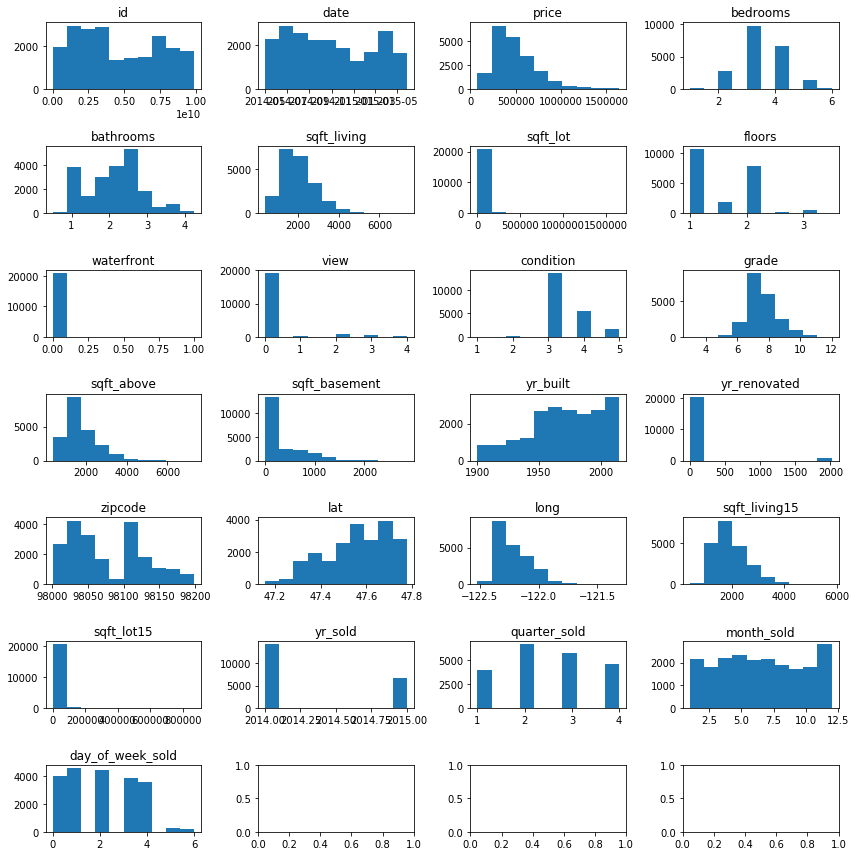

In [45]:
# Distributions: What do distributions of price, bedrooms, bathrooms look like now? Did distributions of other variables change?
distributions_data = df_pp.copy() 

fig, axes = plt.subplots(7,4, figsize=(12,12))
fig.set_tight_layout(True)

for index, col in enumerate(distributions_data.columns):
    ax = axes[index//4][index%4]
    ax.hist(df_pp[col])
    
    ax.set_title(col)
    
fig.tight_layout()    

In [46]:
df_pp.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,quarter_sold,month_sold,day_of_week_sold
count,2.104100e+04,2.104100e+04,21041.000000,21041.000000,21041.000000,2.104100e+04,21041.000000,21041.000000,21041.000000,21041.000000,...,21041.000000,21041.000000,21041.000000,21041.000000,21041.000000,21041.000000,21041.000000,21041.000000,21041.000000,21041.000000
mean,4.595098e+09,5.043334e+05,3.336961,2.071717,2018.082078,1.470187e+04,1.484007,0.003707,0.202129,3.409296,...,64.593746,98078.321658,47.558783,-122.213954,1955.245235,12533.997291,2014.322751,2.525735,6.577492,2.010598
std,2.877560e+09,2.565491e+05,0.862256,0.709795,816.495533,3.987315e+04,0.537844,0.060774,0.701822,0.649625,...,353.207922,53.426080,0.139623,0.141378,648.491854,26451.605438,0.467539,1.033615,3.113871,1.462306
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,...,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,1.000000,1.000000,0.000000
25%,2.126059e+09,3.199500e+05,3.000000,1.500000,1410.000000,5.001000e+03,1.000000,0.000000,0.000000,3.000000,...,0.000000,98033.000000,47.466300,-122.330000,1480.000000,5080.000000,2014.000000,2.000000,4.000000,1.000000
50%,3.905041e+09,4.450000e+05,3.000000,2.250000,1890.000000,7.555000e+03,1.000000,0.000000,0.000000,3.000000,...,0.000000,98065.000000,47.569700,-122.231000,1820.000000,7566.000000,2014.000000,2.000000,6.000000,2.000000
75%,7.334600e+09,6.250000e+05,4.000000,2.500000,2490.000000,1.045500e+04,2.000000,0.000000,0.000000,4.000000,...,0.000000,98118.000000,47.678800,-122.124000,2320.000000,9997.000000,2015.000000,3.000000,9.000000,3.000000
max,9.900000e+09,1.640000e+06,6.000000,4.250000,7350.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,871200.000000,2015.000000,4.000000,12.000000,6.000000


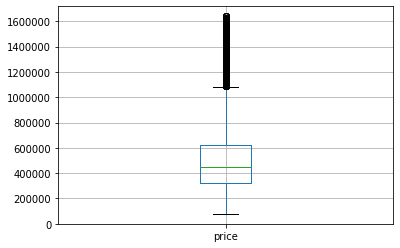

In [47]:
df_pp.boxplot(column = 'price')

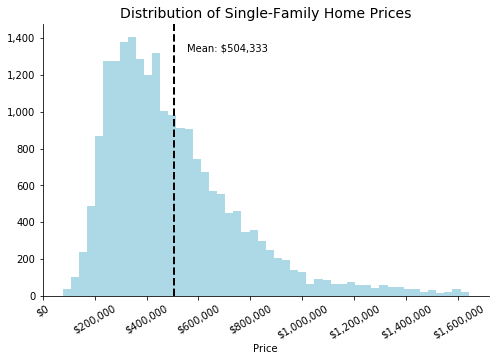

In [48]:
fig, ax = plt.subplots(figsize = (8,5))

df_pp.price.hist(bins=50, facecolor='lightblue')

#add vertical line representing mean price
plt.axvline(df_pp.price.mean(), color='black', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(df_pp.price.mean()*1.1, max_ylim*0.9, 'Mean: ${:,.0f}'.format(df_pp.price.mean()))

#format xticks
ax.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.xticks(rotation=30)
plt.xlabel('Price')

#format yticks
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

#remove grid line
plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#title
plt.title('Distribution of Single-Family Home Prices', fontsize=14)

plt.show;

In [49]:
# Mean vs median values for price, bedrooms, bathrooms, sqft_living
print('Price mean: ', df_pp.price.mean().round(2))
print('Price median: ', df_pp.price.median().round(2))
print('-----------------------')
print('Bedrooms mean: ', df_pp.bedrooms.mean().round(2))
print('Bedrooms median: ', df_pp.bedrooms.median().round(2))
print('-----------------------')
print('Bathrooms mean: ', df_pp.bathrooms.mean().round(2))
print('Bathrooms median: ', df_pp.bathrooms.median().round(2)) 
print('-----------------------')
print('sqft_living mean: ', df_pp.sqft_living.mean().round(2))
print('sqft_living median: ', df_pp.sqft_living.median().round(2)) 

Price mean:  504333.45
Price median:  445000.0
-----------------------
Bedrooms mean:  3.34
Bedrooms median:  3.0
-----------------------
Bathrooms mean:  2.07
Bathrooms median:  2.25
-----------------------
sqft_living mean:  2018.08
sqft_living median:  1890.0


- Removing outliers improved the distribution of bedrooms most notably. Price, bathroom distributions are also less skewed, but remain skewed--price is still positively skewed (mean>median, and bathrooms is negatively skewed (median>mean). Maximum price is now $1.6M (down from $7.7M), max bedrooms is 6 (down from 33), and max bathrooms is 4.25 (down from 7.75). These values are more representative of values that would be expected for single-family homes.
- Distribution of sqft_living also improved as a result of removing outliers of price, bedrooms, and bathrooms. Max sqft_living is now 7350 (down from 13,540). Nonetheless, all sqft variables remain positively skewed.
- Price and sqft variables may need to be log transformed. 

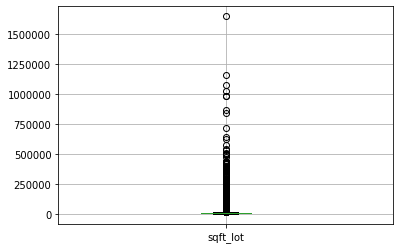

In [50]:
# Sqft_lot appears to have one very large outlier that can be replaced with mean
df_pp.boxplot(column = 'sqft_lot')

In [51]:
df_pp.sqft_lot.max()

1651359

In [52]:
df_pp.sqft_lot.replace(df_pp.sqft_lot.max(), df_pp.sqft_lot.mean(), inplace=True)
#df_pp.sqft_lot.replace([233481], df_pp.sqft_lot.mean(), inplace=True)

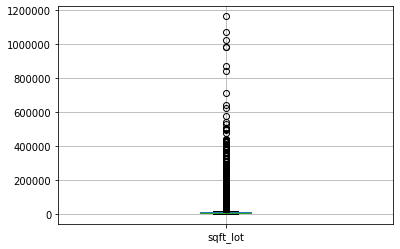

In [53]:
df_pp.boxplot(column = 'sqft_lot')

# Exploratory Data Analysis

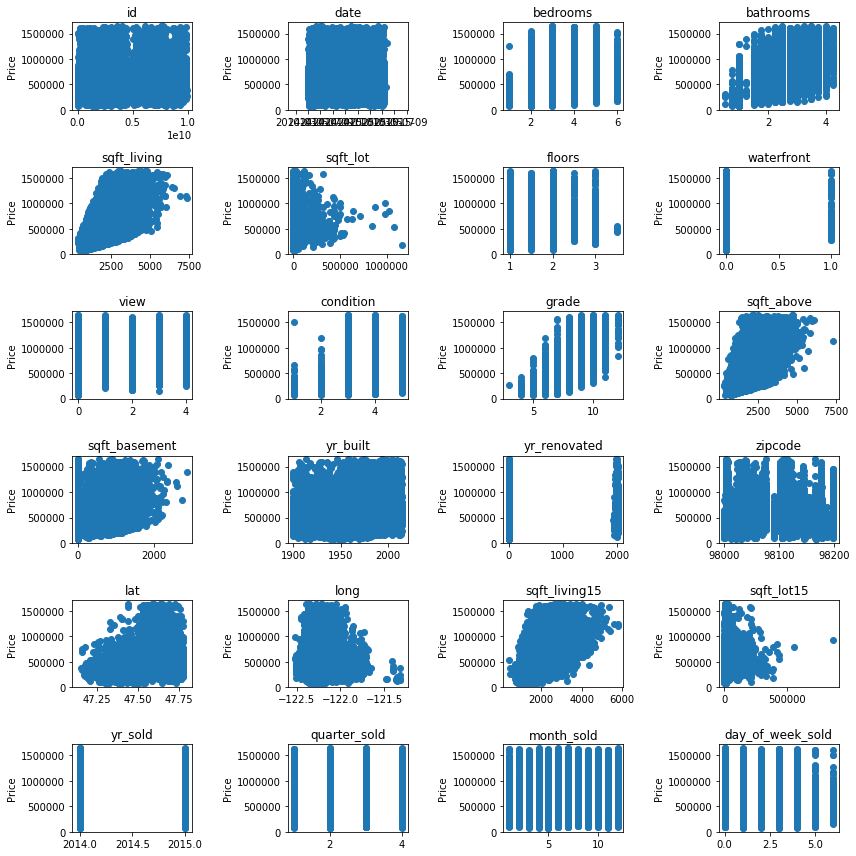

In [54]:
# Scatterplots of price and features
scatterplot_data = df_pp.drop(['price'], axis =1)

fig, axes = plt.subplots(6,4, figsize=(12,12))
fig.set_tight_layout(True)

for index, col in enumerate(scatterplot_data):
    ax = axes[index//4][index%4]
    ax.scatter(df_pp[col], df_pp['price'])
    #ax.set_xlabel(col)
    ax.set_ylabel('Price')
    
    ax.set_title(col)
    
fig.tight_layout()    
plt.show();

- Several variables have clear linear relationship with price, in particular: sqft_living, grade. 
- bedrooms, bathrooms, sqft_above, sqft_living15 also have linear relationship with price.
- Latitude has a stronger linear relationship with price than longitude, suggesting that the North-South location of the home is important for its price.
- Date-extracted variables (quarter_sold, month_sold, day of week sold) do not appear to show linear relationship with price, nor are they home features, but they could provide useful insights into market trends.
- Zipcode can be treated as categorical. Waterfont is boolean variable, and can be treated as categorical.
- Other variables that could be treated as categorical (not continuous): bedrooms, bathrooms, floors, view, condition, grade, yr_renovated.

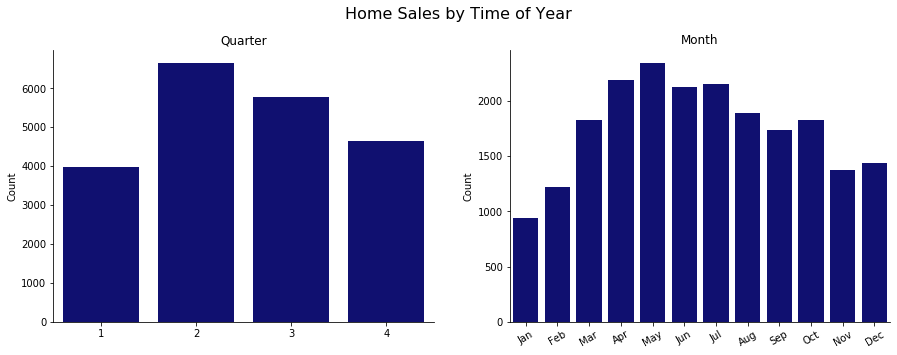

In [55]:
# Plot sales by quarter, month, and day of week
fig, axes = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Home Sales by Time of Year', fontsize=16, y=1)

sns.countplot(
    df_pp['quarter_sold'], color='navy', ax=axes[0]
    ).set(
    title='Quarter', 
    xlabel=None, 
    ylabel='Count');

month_name = df_pp['date'].dt.month_name().str[:3] 
month_order = ['Jan','Feb','Mar','Apr','May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.countplot(
    month_name, color='navy', order=month_order, ax=axes[1]
    ).set(
    title='Month', 
    xlabel=None, 
    ylabel='Count');

axes[1].tick_params(axis="x", rotation=30)

sns.despine(ax=axes[0])
sns.despine(ax=axes[1])

fig.show();

- Number of home sales is higher in Q2 and Q3, and the months of spring/summer months of April, May, June, July in particular.
- Q1 is a slower period for home sales. By month, number of home sales in Jan and Feb are particularly lower than other months. 

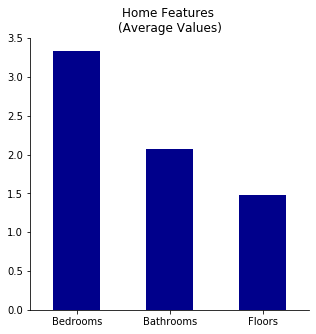

In [56]:
# Barplots of average number of bedrooms, bathrooms, sqft_above: for presentation slides
fig, ax = plt.subplots(figsize=(5,5))

data=df_pp[['bedrooms', 'bathrooms', 'floors']]
data = data.rename(columns={'bedrooms': 'Bedrooms', 'bathrooms': 'Bathrooms', 'floors': 'Floors'})
data.mean().plot(kind='bar', color='darkblue')

plt.xticks(rotation=0)

sns.despine()

plt.title('Home Features \n(Average Values)')

plt.show;

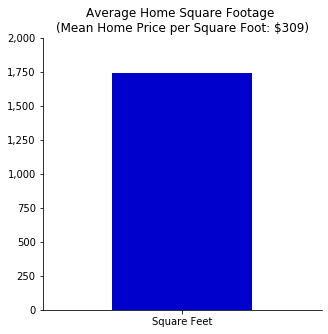

In [57]:
# Barplot of average square footage: for presentation slides
fig, ax = plt.subplots(figsize=(5,5))

data=df_pp[['sqft_above']]
data = data.rename(columns={'sqft_above': 'Square Feet'})
data.mean().plot(kind='bar', color='mediumblue')

#format ticks
plt.xticks(rotation=0)
ax.set_ylim([0, 2000])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

sns.despine()

plt.title('Average Home Square Footage \n(Mean Home Price per Square Foot: $309)')

plt.show;

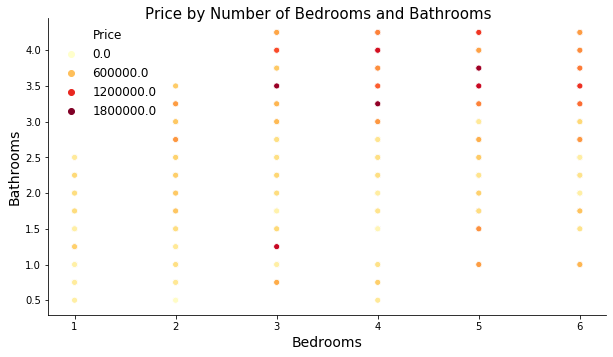

In [58]:
# Scatterplot of number of bedrooms vs. bathrooms, and how this relates to price

data = df_pp.rename(columns={'price': 'Price', 'bathrooms': 'Bathrooms', 'bedrooms': 'Bedrooms'})
fig = plt.gcf()
sns.scatterplot(data.Bedrooms, data.Bathrooms, hue = data.Price,  \
                          palette="YlOrRd", legend="brief").legend(loc='upper left',   \
                                                                   fontsize = 12, frameon = False)


fig.set_size_inches(10, 5)

plt.xlabel('Bedrooms',size=14)
plt.ylabel('Bathrooms',size=14)
sns.despine()

fig.suptitle('Price by Number of Bedrooms and Bathrooms', fontsize = 15)
fig.subplots_adjust(top=0.95)

- Unsurprisingly, homes with more bedrooms and bathrooms sell for higher prices. What is the relationship between bedrooms and bathrooms that matters for price?

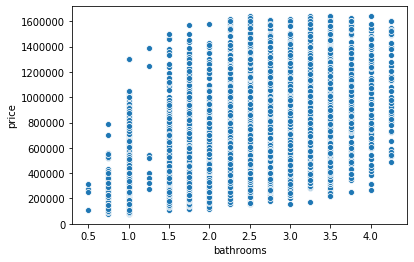

In [59]:
#bathrooms/bedroom vs. price
sns.scatterplot(df_pp.bathrooms, df_pp.price)

In [60]:
# Create new variable: age of house when sold
df_pp['age'] = df_pp.yr_sold - df_pp.yr_built

In [61]:
df_pp.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,quarter_sold,month_sold,day_of_week_sold,age
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650.0,1.0,0.0,0.0,...,98178,47.5112,-122.257,1340,5650,2014,4,10,0,59
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242.0,2.0,0.0,0.0,...,98125,47.7210,-122.319,1690,7639,2014,4,12,1,63
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000.0,1.0,0.0,0.0,...,98028,47.7379,-122.233,2720,8062,2015,1,2,2,82
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000.0,1.0,0.0,0.0,...,98136,47.5208,-122.393,1360,5000,2014,4,12,1,49
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080.0,1.0,0.0,0.0,...,98074,47.6168,-122.045,1800,7503,2015,1,2,2,28


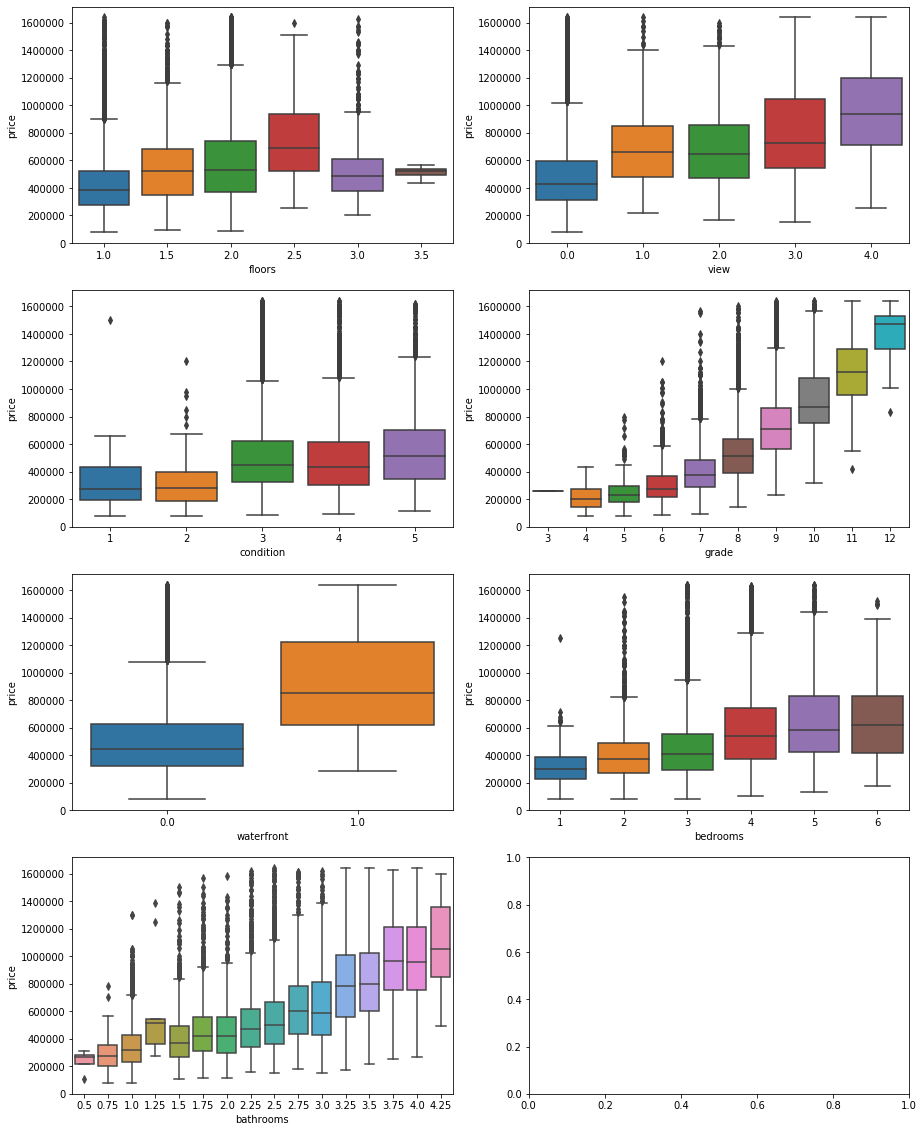

In [62]:
# Boxplots of price and variables that could be treated as categoricals
# floors, view, condition, grade, waterfront, bedrooms, bathrooms, zipcode, yr_built
fig, axes = plt.subplots(4,2, figsize = (15,20))

sns.boxplot(data = df_pp, x='floors', y = 'price', ax = axes[0,0])

sns.boxplot(data = df_pp, x= 'view', y = 'price', ax = axes[0,1])

sns.boxplot(data = df_pp, x= 'condition', y = 'price', ax = axes[1,0])

sns.boxplot(data = df_pp, x= 'grade', y = 'price', ax = axes[1,1])

sns.boxplot(data = df_pp, x= 'waterfront', y = 'price', ax = axes[2,0])

sns.boxplot(data = df_pp, x= 'bedrooms', y = 'price', ax = axes[2,1])

sns.boxplot(data = df_pp, x= 'bathrooms', y = 'price', ax = axes[3,0])

- grade, bathrooms, views have clearest positive relationships with price.
- floors: more floors are associated with a higher price, up to a certain number of floors. More than 3 floors is related with lower price compared to 2 and 2.5 floors.
- bedrooms: more bedrooms are associated with a higher price, up to 4 bedrooms. After that, it does not look like homes with additional bedrooms are sold at a much higher price.
- condition: values 3, 4, and 5 associated with higher price.
- floors and bedrooms could be treated as categorical in order to better determine the characteristics of each one that are associated with price.

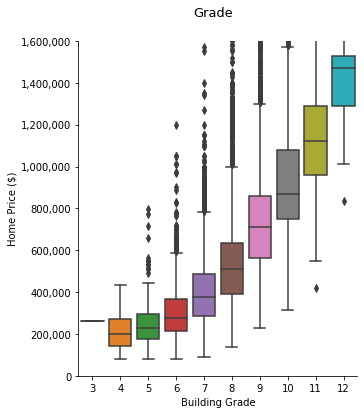

In [63]:
# for presenation slides

fig, ax = plt.subplots(figsize = (5,6))

sns.boxplot(data = df_pp, x= 'grade', y = 'price')

ax.set(xlabel='Building Grade', ylabel='Home Price ($)')

ax.set_ylim([0, 1600000])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

sns.despine()

fig.suptitle('Grade', size=13)
fig.subplots_adjust(top=0.9)

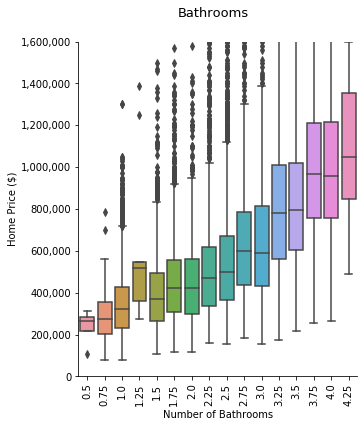

In [64]:
# for presentation slides

fig, ax = plt.subplots(figsize = (5,6))

#order = df_processed.groupby(by=["condition_labels"])["price"].median().sort_values().index

sns.boxplot(data = df_pp, x= 'bathrooms', y = 'price')

ax.set(xlabel='Number of Bathrooms', ylabel='Home Price ($)')

ax.tick_params(axis="x", rotation=90)

ax.set_ylim([0, 1600000])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

sns.despine()

fig.suptitle('Bathrooms', size=13)
fig.subplots_adjust(top=0.9)

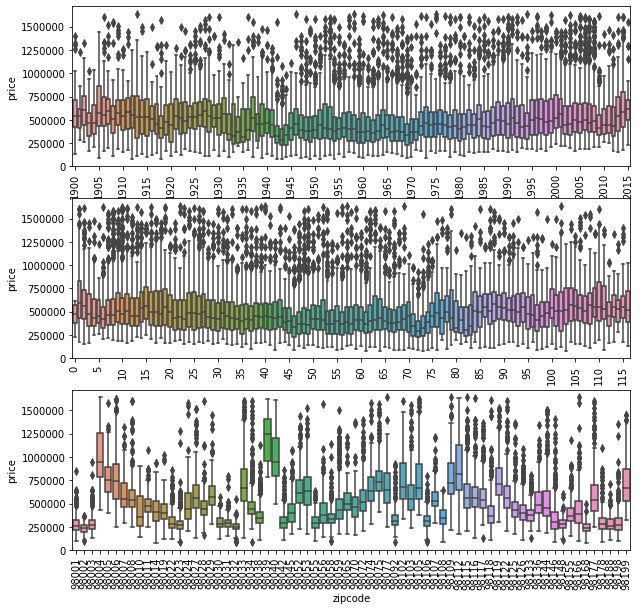

In [65]:
fig, axes = plt.subplots(3, figsize = (10,10))

#yr_built boxplot
yr_built_boxplot = sns.boxplot(data = df_pp, x= 'yr_built', y = 'price', ax = axes[0])
axes[0].tick_params(axis="x", rotation=90)
# reduce x-tick label frequency to make more readable
axes[0].set_xticks(np.arange(0, 120, 5))
axes[0].set_xticklabels(np.arange(1900, 2020, 5))

#age boxplot
yr_built_boxplot = sns.boxplot(data = df_pp, x= 'age', y = 'price', ax = axes[1])
axes[1].tick_params(axis="x", rotation=90)
# reduce x-tick label frequency to make more readable
axes[1].set_xticks(np.arange(0, 120, 5))
axes[1].set_xticklabels(np.arange(0, 120, 5))

#zipcode boxplot        
zipcode_boxplot = sns.boxplot(data = df_pp, x= 'zipcode', y = 'price', ax = axes[2])
axes[2].tick_params(axis="x", rotation=90)

- yr_built does not have strong linear relationship with price, but it seems that some periods are associated with higher/lower prices. Explore whether treating as categorical variables would help.
- Zipcode also does not have clear linear relationship with price.
- yr_built and zipcode are candidates for one hot encoding. There is no ordering or relationship between the categories and price.

In [66]:
# Explore age distribution and price by age
df_pp.yr_built.describe()

count    21041.000000
mean      1970.866641
std         29.269087
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1996.000000
max       2015.000000
Name: yr_built, dtype: float64

In [67]:
mean_price_by_yr_built = df_pp.groupby('yr_built')['price'].mean()
mean_price_by_yr_built.sort_values(ascending=True)

yr_built
1943    333347.000000
1944    356322.078571
1942    366456.022624
1969    388452.036630
1962    417123.534426
            ...      
1907    622398.269841
1902    622546.153846
2014    632328.263551
2015    664937.970588
1905    678069.300000
Name: price, Length: 116, dtype: float64

In [68]:
df_pp.price.mean()

504333.44565372367

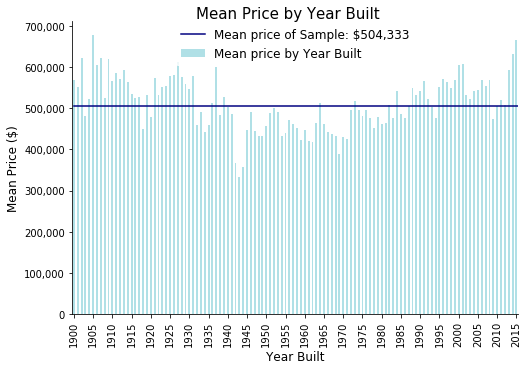

In [69]:
fig, ax = plt.subplots(figsize = (8,5))

data = df_pp
data['price_mean'] = df_pp.price.mean()

barplot = mean_price_by_yr_built.plot(kind='bar', color='powderblue', label='Mean price by Year Built')
data['price_mean'].plot(kind='line', color = 'navy', label = 'Mean price of Sample: $504,333')

plt.ylabel('Mean Price ($)',size=12)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.xlabel('Year Built', size=12)
plt.xticks(rotation=90)
ax.set_xticks(np.arange(0, 120, 5))
ax.set_xticklabels(np.arange(1900,2020,5))

plt.legend(loc='upper center', borderaxespad=0.2, edgecolor='white', fontsize=12)
fig.suptitle('Mean Price by Year Built', fontsize=15)
fig.subplots_adjust(top=0.94)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show();

- Homes built in the early 1900 up to 1930s, and newer homes built from 1990 onwards generally are sold at prices above the sample mean price of $504,333. Homes built from 1940-1990 generally are sold at prices below the sample mean price.

Text(0.5, 1.0, 'Distribution of Zipcode')

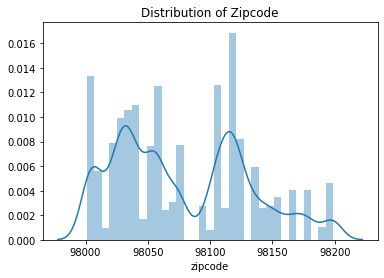

In [70]:
#Explore zipcode distribution
sns.distplot(df_pp.zipcode)
plt.title('Distribution of Zipcode')

In [71]:
# Find average price by zipcode
mean_price_by_zip = df_pp.groupby('zipcode')['price'].mean()
mean_price_by_zip.sort_values(ascending=True)

zipcode
98002    2.326047e+05
98168    2.389863e+05
98032    2.512962e+05
98001    2.811949e+05
98188    2.841616e+05
             ...     
98109    8.037716e+05
98112    8.881257e+05
98040    1.002645e+06
98004    1.019075e+06
98039    1.217500e+06
Name: price, Length: 70, dtype: float64

In [72]:
df_pp.zipcode.mean()

98078.32165771589

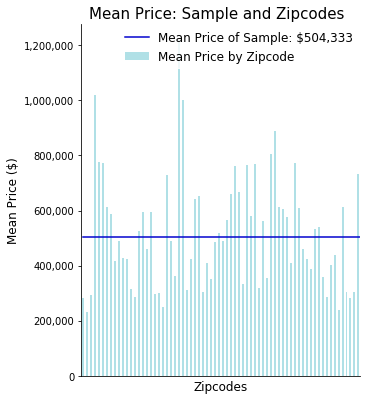

In [73]:
# Plot average price by zipcode, and add line chart representing sample's mean price.

fig, ax = plt.subplots(figsize = (5,6))
data = df_pp
data['price_mean'] = data.price.mean()

mean_price_by_zip.plot(kind='bar', color='powderblue', label='Mean Price by Zipcode')
data['price_mean'].plot(kind='line', color = 'mediumblue', label = 'Mean Price of Sample: $504,333')

plt.ylabel('Mean Price ($)',size=12)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.xlabel('Zipcodes', size=12)
plt.xticks([])

plt.legend(loc='upper right', borderaxespad=0.2, edgecolor='white', fontsize=12)
fig.suptitle('Mean Price: Sample and Zipcodes', fontsize=15)
fig.subplots_adjust(top=0.94)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show();

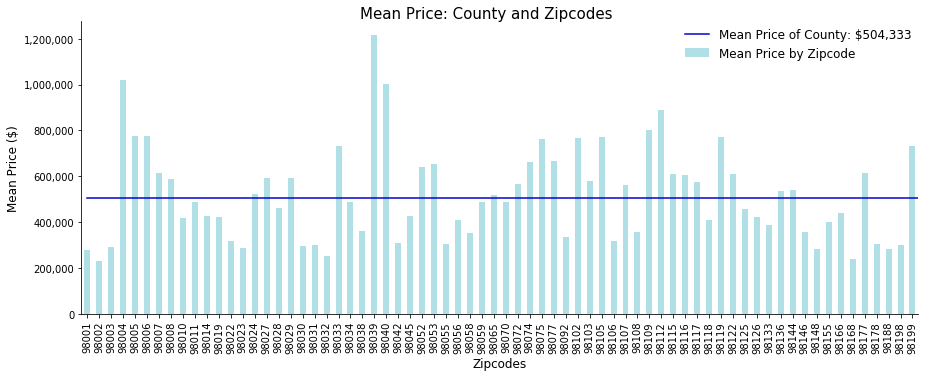

In [74]:
# Plot average price by zipcode, and add line chart representing sample's mean price.

fig, ax = plt.subplots(figsize = (15,5))
data = df_pp
data['price_mean'] = data.price.mean()

mean_price_by_zip.plot(kind='bar', color='powderblue', label='Mean Price by Zipcode')
data['price_mean'].plot(kind='line', color = 'mediumblue', label = 'Mean Price of County: $504,333')

plt.ylabel('Mean Price ($)',size=12)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.xlabel('Zipcodes', size=12)
plt.xticks(rotation=90)

plt.legend(loc='upper right', borderaxespad=0.2, edgecolor='white', fontsize=12)
fig.suptitle('Mean Price: County and Zipcodes', fontsize=15)
fig.subplots_adjust(top=0.94)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show();

- Zipcode variable does not have normal distribution.
- Mean price varies notably by zipcode. Homes in some select zipcodes have higher mean prices than other zipcodes. There is no order in the relationship of zipcode categories and price.

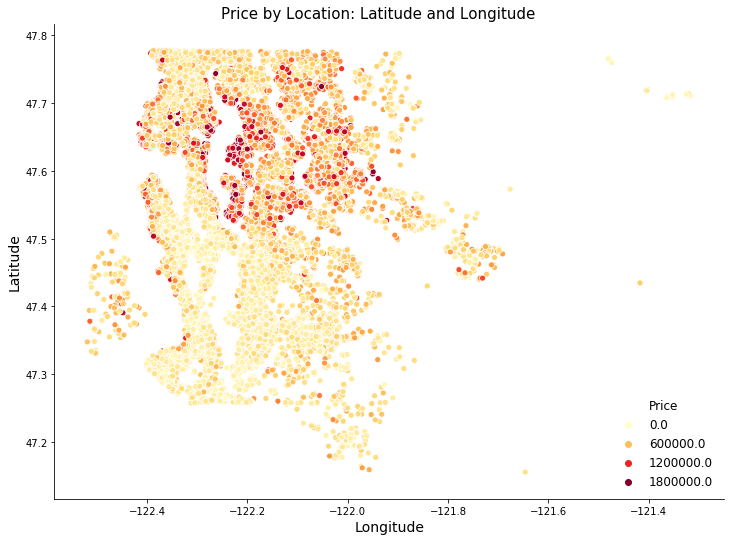

In [75]:
# Explore geolocation data (latitute, longitude)
# Scatterplot of longitude (north-south) and latitude (east-west)

data = df_pp.rename(columns={'price': 'Price', 'long': 'Longitute', 'lat': 'Latitude'})
fig = plt.gcf()

fig.set_size_inches(12, 8)

sns.scatterplot(data.Longitute, data.Latitude, hue = data.Price,  \
                          palette="YlOrRd", legend="brief").legend(loc='lower right',   \
                                                                   fontsize = 12, frameon = False)

plt.xlabel('Longitude',size=14)
plt.ylabel('Latitude',size=14)
sns.despine()

fig.suptitle('Price by Location: Latitude and Longitude', fontsize = 15)
fig.subplots_adjust(top=0.95)

In [76]:
# Number of zipcodes with mean price > sample mean price and number with mean price < sample mean price
price_sample_mean = df_pp.price.mean()
(mean_price_by_zip >= price_sample_mean).value_counts()

False    37
True     33
Name: price, dtype: int64

- 33 zipcodes have mean price that is greater than the sample's mean price of $504,333.
- 37 zipcodes have mean price that is below sample's mean price.

In [77]:
df_pp.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_sold', 'quarter_sold',
       'month_sold', 'day_of_week_sold', 'age', 'price_mean'],
      dtype='object')

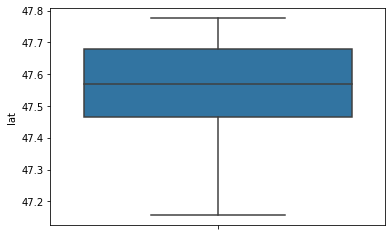

In [78]:
ax = sns.boxplot(x="lat", data=df_pp, orient='v')

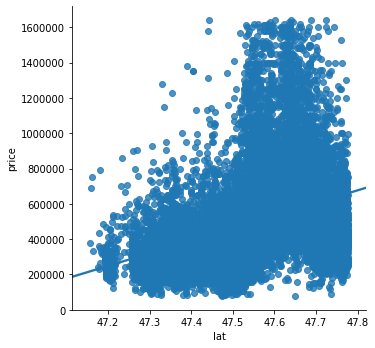

In [79]:
sns.pairplot(data=df_pp,
            x_vars=['lat'],
            y_vars=['price'], 
            kind="reg",
            height = 5)

- Location (in this case, determined by latitude) is an important feature of housing prices, but the relationship is not linear.

#### Locate and load city zipcodes.  This will help make zipcode data more interpretable.

- Data on zipcodes by city obtained from King County GIS Open Data 
- https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/about

In [80]:
# Load zipcodes df. This was obtained from King County GIS Open Data
df_zips = pd.read_csv('data/zipcodes.csv')

In [81]:
df_zips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBJECTID        209 non-null    int64  
 1   ZIP             209 non-null    int64  
 2   ZIPCODE         209 non-null    int64  
 3   COUNTY          209 non-null    int64  
 4   ZIP_TYPE        209 non-null    object 
 5   Shape_Length    209 non-null    float64
 6   Shape_Area      209 non-null    float64
 7   COUNTY_NAME     209 non-null    object 
 8   PREFERRED_CITY  209 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 14.8+ KB


In [82]:
df_zips.head()

,OBJECTID,ZIP,ZIPCODE,COUNTY,ZIP_TYPE,Shape_Length,Shape_Area,COUNTY_NAME,PREFERRED_CITY
0,1,98001,98001,33,Standard,148134.770976,5.261214e+08,King County,AUBURN
1,2,98002,98002,33,Standard,105168.476815,2.044452e+08,King County,AUBURN
2,3,98003,98003,33,Standard,121645.070704,3.169812e+08,King County,FEDERAL WAY
3,4,98004,98004,33,Standard,99252.932327,2.505466e+08,King County,BELLEVUE
4,5,98005,98005,33,Standard,116930.355168,2.112733e+08,King County,BELLEVUE


In [83]:
df_zips.ZIPCODE.nunique()

198

In [84]:
df_zips.COUNTY_NAME.value_counts()

King County         87
Pierce County       60
Snohomish County    33
Kitsap County       18
Kittitas County     10
Chelan County        1
Name: COUNTY_NAME, dtype: int64

- The dataset includes zipcodes for other counties. Need to narrow dataset down to only King County.

In [85]:
# Drop columns that are not needed for zipcode, city joining. Keep zipcode, county name, preferred city.
df_zips.drop(['OBJECTID', 'ZIP', 'COUNTY', 'ZIP_TYPE', 'Shape_Length', 'Shape_Area'], axis=1, inplace=True)

In [86]:
# Rename columns
column_names = {'ZIPCODE':'zipcode', 'COUNTY_NAME':'county', 'PREFERRED_CITY':'city'}
df_zips.rename(columns=column_names, inplace=True)

In [87]:
# Drop zipcodes that are not in King County
df_zips = df_zips[df_zips['county']=="King County"]
df_zips.shape

(87, 3)

In [88]:
df_zips.county.value_counts()

King County    87
Name: county, dtype: int64

In [89]:
# Convert City values from all caps to title case. Replace space with underscore in County and City values.
df_zips.head()

,zipcode,county,city
0,98001,King County,AUBURN
1,98002,King County,AUBURN
2,98003,King County,FEDERAL WAY
3,98004,King County,BELLEVUE
4,98005,King County,BELLEVUE


In [90]:
df_zips.city = df_zips.city.str.title().replace(" ", "_", regex=True)

In [91]:
df_zips.county = df_zips.county.str.title().replace(" ", "_", regex=True)

In [92]:
df_zips

,zipcode,county,city
0,98001,King_County,Auburn
1,98002,King_County,Auburn
2,98003,King_County,Federal_Way
3,98004,King_County,Bellevue
4,98005,King_County,Bellevue
...,...,...,...
100,98199,King_County,Seattle
108,98224,King_County,Baring
118,98288,King_County,Skykomish
147,98354,King_County,Milton


In [93]:
df_zips.city.value_counts()

Seattle            37
Renton              5
Bellevue            5
Kent                4
Auburn              3
Redmond             2
Woodinville         2
Issaquah            2
Federal_Way         2
Kirkland            2
Fall_City           1
Bothell             1
Medina              1
Preston             1
Sammamiish          1
Maple_Valley        1
Enumclaw            1
Carnation           1
Sammamish           1
Kenmore             1
Skykomish           1
North_Bend          1
Snoqualmie_Pass     1
Baring              1
Snoqualmie          1
Ravensdale          1
Tacoma              1
Black_Diamond       1
Mercer_Island       1
Milton              1
Duvall              1
Vashon              1
Pacific             1
Name: city, dtype: int64

In [94]:
df_zips.city.replace('Sammamiish', 'Sammamish', inplace=True)
df_zips.city.value_counts()

Seattle            37
Bellevue            5
Renton              5
Kent                4
Auburn              3
Redmond             2
Woodinville         2
Issaquah            2
Federal_Way         2
Sammamish           2
Kirkland            2
Snoqualmie_Pass     1
Snoqualmie          1
Medina              1
Preston             1
Maple_Valley        1
Enumclaw            1
Carnation           1
Bothell             1
Kenmore             1
Skykomish           1
North_Bend          1
Vashon              1
Baring              1
Tacoma              1
Ravensdale          1
Black_Diamond       1
Fall_City           1
Mercer_Island       1
Milton              1
Duvall              1
Pacific             1
Name: city, dtype: int64

In [95]:
#Create dictionary with key, value: zipcode, city
zips_dictionary = dict(zip(df_zips.zipcode, df_zips.city))
zips_dictionary

{98001: 'Auburn',
 98002: 'Auburn',
 98003: 'Federal_Way',
 98004: 'Bellevue',
 98005: 'Bellevue',
 98006: 'Bellevue',
 98007: 'Bellevue',
 98008: 'Bellevue',
 98010: 'Black_Diamond',
 98011: 'Bothell',
 98014: 'Carnation',
 98019: 'Duvall',
 98022: 'Enumclaw',
 98023: 'Federal_Way',
 98024: 'Fall_City',
 98027: 'Issaquah',
 98028: 'Kenmore',
 98029: 'Issaquah',
 98030: 'Kent',
 98031: 'Kent',
 98032: 'Kent',
 98033: 'Kirkland',
 98034: 'Kirkland',
 98038: 'Maple_Valley',
 98039: 'Medina',
 98040: 'Mercer_Island',
 98042: 'Kent',
 98045: 'North_Bend',
 98047: 'Pacific',
 98050: 'Preston',
 98051: 'Ravensdale',
 98052: 'Redmond',
 98053: 'Redmond',
 98055: 'Renton',
 98056: 'Renton',
 98057: 'Renton',
 98058: 'Renton',
 98059: 'Renton',
 98065: 'Snoqualmie',
 98068: 'Snoqualmie_Pass',
 98070: 'Vashon',
 98072: 'Woodinville',
 98074: 'Sammamish',
 98075: 'Sammamish',
 98077: 'Woodinville',
 98092: 'Auburn',
 98101: 'Seattle',
 98102: 'Seattle',
 98103: 'Seattle',
 98104: 'Seattle',
 9810

In [96]:
# Create new column in df_pp that has zipcode values. 
df_pp['city'] = df_pp.zipcode
df_pp['city']

0        98178
1        98125
2        98028
3        98136
4        98074
         ...  
21592    98103
21593    98146
21594    98144
21595    98027
21596    98144
Name: city, Length: 21041, dtype: int64

In [97]:
# Call on dictionary to replace zipcode values in new column with city names.
df_pp.replace({'city': zips_dictionary}, inplace=True)

In [98]:
df_pp.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,yr_sold,quarter_sold,month_sold,day_of_week_sold,age,price_mean,city
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650.0,1.0,0.0,0.0,...,-122.257,1340,5650,2014,4,10,0,59,504333.445654,Seattle
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242.0,2.0,0.0,0.0,...,-122.319,1690,7639,2014,4,12,1,63,504333.445654,Seattle
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000.0,1.0,0.0,0.0,...,-122.233,2720,8062,2015,1,2,2,82,504333.445654,Kenmore
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000.0,1.0,0.0,0.0,...,-122.393,1360,5000,2014,4,12,1,49,504333.445654,Seattle
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080.0,1.0,0.0,0.0,...,-122.045,1800,7503,2015,1,2,2,28,504333.445654,Sammamish


In [99]:
df_pp.city.value_counts()

Seattle          8777
Renton           1584
Bellevue         1263
Kent             1197
Redmond           960
Kirkland          941
Auburn            907
Sammamish         778
Federal_Way       777
Issaquah          717
Maple_Valley      587
Woodinville       465
Snoqualmie        303
Kenmore           282
Mercer_Island     238
Enumclaw          233
North_Bend        217
Bothell           195
Duvall            190
Carnation         121
Vashon            117
Black_Diamond      99
Fall_City          75
Medina             18
Name: city, dtype: int64

In [100]:
# Mean price by city
mean_price_by_city = df_pp.groupby('city')['price'].mean()
mean_price_by_city.sort_values(ascending=True)

city
Federal_Way      2.884503e+05
Auburn           2.914875e+05
Kent             2.987126e+05
Enumclaw         3.167424e+05
Maple_Valley     3.640322e+05
Renton           3.974786e+05
Black_Diamond    4.185010e+05
Duvall           4.248151e+05
North_Bend       4.256733e+05
Carnation        4.265002e+05
Kenmore          4.620048e+05
Vashon           4.893820e+05
Bothell          4.903771e+05
Seattle          5.063906e+05
Snoqualmie       5.198250e+05
Fall_City        5.247822e+05
Issaquah         5.936843e+05
Kirkland         5.941734e+05
Woodinville      6.077882e+05
Redmond          6.462019e+05
Sammamish        7.054059e+05
Bellevue         7.606183e+05
Mercer_Island    1.002645e+06
Medina           1.217500e+06
Name: price, dtype: float64

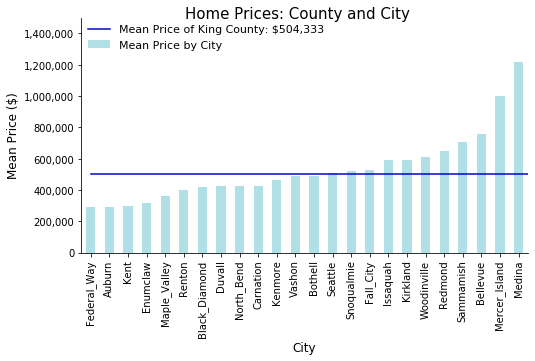

In [101]:
# Plot average price by city, and add line chart representing mean price.

fig, ax = plt.subplots(figsize = (8,4))
data = df_pp
data['price_mean'] = data.price.mean()

mean_price_by_city.sort_values(ascending=True).plot(kind='bar', color='powderblue', label='Mean Price by City')
data['price_mean'].plot(kind='line', color = 'mediumblue', label = 'Mean Price of King County: $504,333')

plt.ylabel('Mean Price ($)',size=12)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.xlabel('City', size=12)
plt.xticks(rotation=90)
ax.set_ylim([0, 1500000])

plt.legend(loc='upper left', borderaxespad=0.2, edgecolor='white', fontsize=11)
fig.suptitle('Home Prices: County and City', fontsize=15)
fig.subplots_adjust(top=0.94)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show();

In [102]:
# Create new variables: price per sqft, and mean price per sqft by city
df_pp['price_sqft'] = df_pp.price / df_pp.sqft_above
mean_price_sqft_by_city = df_pp.groupby('city')['price_sqft'].mean()
mean_price_sqft_by_city.sort_values(ascending=True)

city
Auburn           167.529932
Kent             179.210396
Federal_Way      179.721483
Maple_Valley     184.172409
Enumclaw         192.849036
Snoqualmie       218.020116
Duvall           218.242155
Renton           220.828621
Black_Diamond    229.939943
North_Bend       233.433214
Carnation        237.410016
Bothell          266.826575
Fall_City        268.528987
Kenmore          272.341368
Woodinville      278.598933
Sammamish        291.264997
Issaquah         291.725390
Redmond          304.801536
Vashon           309.429277
Kirkland         348.710408
Seattle          372.382724
Bellevue         406.882812
Mercer_Island    471.257565
Medina           670.283097
Name: price_sqft, dtype: float64

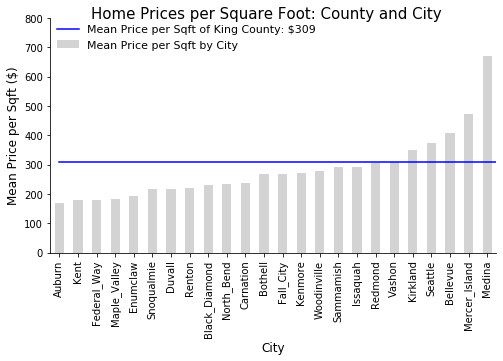

In [103]:
fig, ax = plt.subplots(figsize = (8,4))
data = df_pp

data['price_sqft_mean'] = data.price_sqft.mean()

mean_price_sqft_by_city.sort_values(ascending=True).plot(kind='bar', color='lightgray', label='Mean Price per Sqft by City')
data['price_sqft_mean'].plot(kind='line', color = 'blue', label = 'Mean Price per Sqft of King County: $309')

plt.ylabel('Mean Price per Sqft ($)',size=12)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.xlabel('City', size=12)
plt.xticks(rotation=90)
ax.set_ylim([0, 800])

plt.legend(loc='upper left', borderaxespad=0.2, edgecolor='white', fontsize=11)
fig.suptitle('Home Prices per Square Foot: County and City', fontsize=15)
fig.subplots_adjust(top=0.94)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show();


- Five cities have mean price/sqft above the county mean, down from ten cities that have mean price above the county mean.

In [104]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_sold', 'quarter_sold',
       'month_sold', 'day_of_week_sold', 'age', 'price_mean', 'city',
       'price_sqft', 'price_sqft_mean'],
      dtype='object')

# Data Transformation
- Create dummy variables
- Check for multicollinearity
- Normalize variables

In [105]:
df_pp.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_sold', 'quarter_sold',
       'month_sold', 'day_of_week_sold', 'age', 'price_mean', 'city',
       'price_sqft', 'price_sqft_mean'],
      dtype='object')

In [106]:
# New df for processing. Df is comprised of variables of interest. 
# Drop variables that are unique identifiers and are not home features. Drop yr_built, keep age since these are correlated nearly 1:1.
df_processed = df_pp.drop(['id', 'date', 'view','yr_built','yr_sold', 'quarter_sold','month_sold','day_of_week_sold', 'price_mean', 'view'], axis=1)
df_processed.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'age', 'city', 'price_sqft', 'price_sqft_mean'],
      dtype='object')

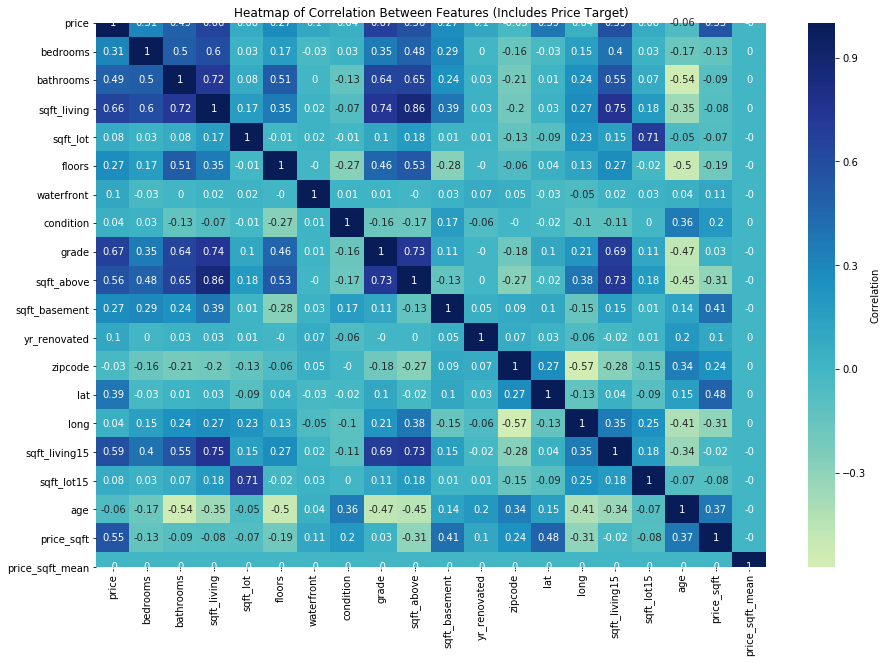

In [107]:
# Plot heatmap of correlation matrix, including the target and predictive variables

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_processed.corr().round(2),
            ax = ax,
            annot= True, center=0, cmap="YlGnBu",
            cbar_kws={"label": "Correlation", "orientation": "vertical", "pad": .05}
)

ax.set_title("Heatmap of Correlation Between Features (Includes Price Target)");

- Selecting which variables to drop because of multicollinearity (correlation >= .75).
- sqft_living and sqft_above exhibit multicollinearity, with correlation of 86%. Keep sqft_above because it is less highly correlated with other features of interest such as grade and bathrooms, and because most people want to live above ground. Create sqft_basement dummy, and remove sqft_basement (which is component of sqft_living).
- sqft_living and sqft_above are highly correlated iwth sqft_living15. Drop sqft_living15.
- sqft_living and grade have high correlation (74%), below 75% threshold, but both are most correlated with price. Consider treating one hot encoding grade, so can use grade dummies in model along with sqft_living.
- yr_built and age are nearly perfectly inversely correlated. Drop age.

In [108]:
# Create dummy variable for basement before dropping sqft_basement from features of interest selection
df_processed.sqft_basement.value_counts()

0.000000       12622
291.851724       442
600.000000       211
500.000000       206
700.000000       202
               ...  
915.000000         1
508.000000         1
176.000000         1
207.000000         1
1890.000000        1
Name: sqft_basement, Length: 279, dtype: int64

In [109]:
df_processed['basement'] = df_processed.sqft_basement
df_processed['basement'] = np.where(df_processed.sqft_basement != 0, 1, df_processed['basement'])
df_processed['basement']

0        0.0
1        1.0
2        0.0
3        1.0
4        0.0
        ... 
21592    0.0
21593    0.0
21594    0.0
21595    0.0
21596    0.0
Name: basement, Length: 21041, dtype: float64

In [110]:
df_processed.basement.value_counts()

0.0    12622
1.0     8419
Name: basement, dtype: int64

In [111]:
# Variables that could be treated as categoricals and be candidates for dummy variable creation
categoricals = ['floors'],['grade'],['condition'],['bedrooms'],['zipcode'],['city']
categoricals

# other candidates that could be treated as categorical: ['bathrooms']

(['floors'], ['grade'], ['condition'], ['bedrooms'], ['zipcode'], ['city'])

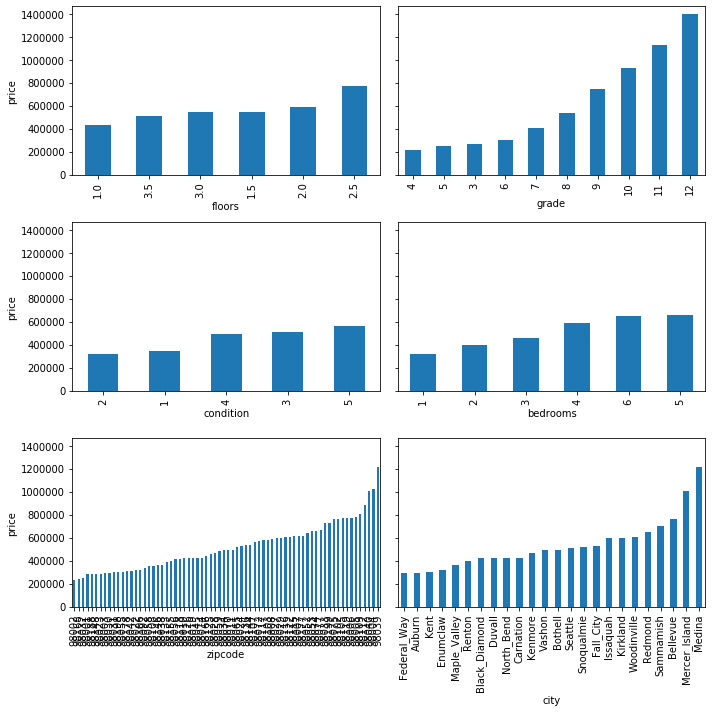

In [112]:
# Visualize categorical variables and price
fig, axes = plt.subplots(3,2, sharey=True, figsize=(10,10))

for col, ax in zip(categoricals, axes.flatten()):
    (df_processed.groupby(col)
        .mean()['price']
        .sort_values()
        .plot.bar(ax=ax))
    #ax.set_title(col)
    ax.set_ylabel('price')

fig.tight_layout()    

### Categorical Variables: Dummies and One Hot Encoding

In [113]:
# create dummy for yr_renovated: y/n
df_processed['renovated'] = np.where(df_processed['yr_renovated']> 0, 1, 0)
df_processed.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,...,lat,long,sqft_living15,sqft_lot15,age,city,price_sqft,price_sqft_mean,basement,renovated
0,221900.0,3,1.00,1180,5650.0,1.0,0.0,3,7,1180,...,47.5112,-122.257,1340,5650,59,Seattle,188.050847,308.748447,0.0,0
1,538000.0,3,2.25,2570,7242.0,2.0,0.0,3,7,2170,...,47.7210,-122.319,1690,7639,63,Seattle,247.926267,308.748447,1.0,1
2,180000.0,2,1.00,770,10000.0,1.0,0.0,3,6,770,...,47.7379,-122.233,2720,8062,82,Kenmore,233.766234,308.748447,0.0,0
3,604000.0,4,3.00,1960,5000.0,1.0,0.0,5,7,1050,...,47.5208,-122.393,1360,5000,49,Seattle,575.238095,308.748447,1.0,0
4,510000.0,3,2.00,1680,8080.0,1.0,0.0,3,8,1680,...,47.6168,-122.045,1800,7503,28,Sammamish,303.571429,308.748447,0.0,0


In [114]:
df_processed.renovated.value_counts()

0    20360
1      681
Name: renovated, dtype: int64

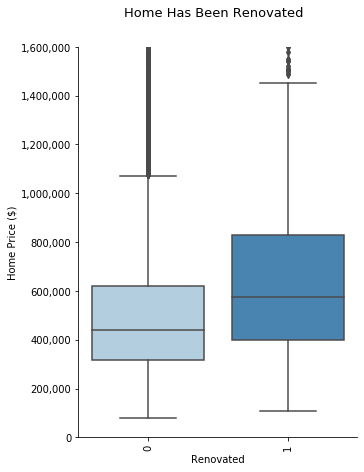

In [115]:
# for project slides

fig, ax = plt.subplots(figsize = (5,7))

ax = sns.boxplot(x="renovated", y='price', data=df_processed, orient='v', palette="Blues")

ax.set(xlabel='Renovated', ylabel='Home Price ($)')

ax.tick_params(axis=("x"), rotation=90)

ax.set_ylim([0, 1600000])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

sns.despine()

fig.suptitle('Home Has Been Renovated', size=13)
fig.subplots_adjust(top=0.9)

In [116]:
df_processed.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'age', 'city', 'price_sqft', 'price_sqft_mean', 'basement',
       'renovated'],
      dtype='object')

In [117]:
# Floors variable suggests that price drops if there too many floors.
# ohe for levels (one level, two levels, three-plus levels). Half floors round up (eg, 2.5 floors = 3 levels)
# Get sense of if people pay more or less for single level vs. multi-level homes. Do people prefer single or multi-story?

bins = pd.IntervalIndex.from_tuples([(0,1), (1,2), (2, 3.5)])

levels_bins = pd.cut(df_processed['floors'], bins)

levels_bins.categories = ['levels_single','levels_two', 'levels_threeplus']

levels_dummies = pd.get_dummies(levels_bins.cat.rename_categories(levels_bins.categories), drop_first=True)

levels_dummies

,levels_two,levels_threeplus
0,0,0
1,1,0
2,0,0
3,0,0
4,0,0
...,...,...
21592,0,1
21593,1,0
21594,1,0
21595,1,0


In [118]:
levels_dummies.levels_two.value_counts()

0    11310
1     9731
Name: levels_two, dtype: int64

In [119]:
# ohe for number of floors
bins = pd.IntervalIndex.from_tuples([(0,1), (1,1.5), (1.5,2), (2,2.5), (2.5,3), (3,3.5)])

fl_bins = pd.cut(df_pp['floors'], bins)

fl_bins.categories = ['floors_1','floors_1.5', 'floors_2','floors_2.5', 'floors_3', 'floors_3.5']

fl_number_dummies = pd.get_dummies(fl_bins.cat.rename_categories(fl_bins.categories), drop_first=True)

fl_number_dummies

,floors_1.5,floors_2,floors_2.5,floors_3,floors_3.5
0,0,0,0,0,0
1,0,1,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
21592,0,0,0,1,0
21593,0,1,0,0,0
21594,0,1,0,0,0
21595,0,1,0,0,0


In [120]:
levels_dummies_test = pd.concat([df_processed.price, df_processed.floors, levels_dummies, fl_number_dummies], axis=1)

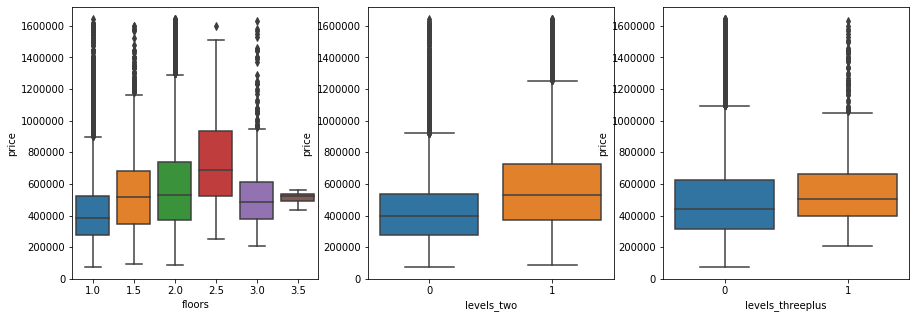

In [121]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.boxplot(data=df_processed, x='floors', y='price', ax = ax[0])
sns.boxplot(data=levels_dummies_test, x='levels_two', y='price', ax = ax[1])
sns.boxplot(data=levels_dummies_test, x='levels_threeplus', y='price', ax = ax[2])

In [122]:
levels_dummies_test.corr().round(2)

,price,floors,levels_two,levels_threeplus,floors_1.5,floors_2,floors_2.5,floors_3,floors_3.5
price,1.00,0.27,0.27,0.06,0.05,0.25,0.08,0.02,0.00
floors,0.27,1.00,0.72,0.50,0.01,0.74,0.15,0.48,0.06
levels_two,0.27,0.72,1.00,-0.18,0.34,0.83,-0.07,-0.16,-0.02
levels_threeplus,0.06,0.50,-0.18,1.00,-0.06,-0.15,0.42,0.90,0.09
floors_1.5,0.05,0.01,0.34,-0.06,1.00,-0.24,-0.02,-0.05,-0.01
floors_2,0.25,0.74,0.83,-0.15,-0.24,1.00,-0.06,-0.13,-0.01
floors_2.5,0.08,0.15,-0.07,0.42,-0.02,-0.06,1.00,-0.01,-0.00
floors_3,0.02,0.48,-0.16,0.90,-0.05,-0.13,-0.01,1.00,-0.00
floors_3.5,0.00,0.06,-0.02,0.09,-0.01,-0.01,-0.00,-0.00,1.00


- Select levels_two and levels_threeplus for model. Levels_two has same price correlation as floors-price correlation (27%), but add more granular insights.

In [123]:
# ohe grade
grade_cat = 'grade'
grade_dummies = pd.get_dummies(df_processed.grade, prefix=grade_cat, drop_first=True)
grade_dummies

,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12
0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
21592,0,0,0,0,1,0,0,0,0
21593,0,0,0,0,1,0,0,0,0
21594,0,0,0,1,0,0,0,0,0
21595,0,0,0,0,1,0,0,0,0


In [124]:
grade_dummies_test_df = pd.concat([df_processed.price, df_processed.grade, grade_dummies], axis=1)

In [125]:
grade_dummies_test_df.corr()

,price,grade,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12
price,1.000000,0.667166,-0.040845,-0.107558,-0.258495,-0.343648,0.082954,0.344204,0.363979,0.264845,0.128880
grade,0.667166,1.000000,-0.117305,-0.254823,-0.475446,-0.465698,0.232965,0.472921,0.481383,0.339106,0.148933
grade_4,-0.040845,-0.117305,1.000000,-0.003866,-0.011735,-0.030798,-0.022682,-0.013261,-0.007884,-0.003923,-0.001332
grade_5,-0.107558,-0.254823,-0.003866,1.000000,-0.035315,-0.092678,-0.068255,-0.039905,-0.023726,-0.011804,-0.004007
grade_6,-0.258495,-0.475446,-0.011735,-0.035315,1.000000,-0.281295,-0.207167,-0.121119,-0.072013,-0.035828,-0.012163
grade_7,-0.343648,-0.465698,-0.030798,-0.092678,-0.281295,1.000000,-0.543671,-0.317854,-0.188984,-0.094024,-0.031919
grade_8,0.082954,0.232965,-0.022682,-0.068255,-0.207167,-0.543671,1.000000,-0.234091,-0.139182,-0.069247,-0.023508
grade_9,0.344204,0.472921,-0.013261,-0.039905,-0.121119,-0.317854,-0.234091,1.000000,-0.081372,-0.040485,-0.013744
grade_10,0.363979,0.481383,-0.007884,-0.023726,-0.072013,-0.188984,-0.139182,-0.081372,1.000000,-0.024071,-0.008171
grade_11,0.264845,0.339106,-0.003923,-0.011804,-0.035828,-0.094024,-0.069247,-0.040485,-0.024071,1.000000,-0.004066


- grades 6, 7, 9, 10, 11, 12 have strongest correlations with price. Grade variable is not strongly correlated with the grade dummy variables.

In [126]:
# Prepare condition for ohe
df_processed.condition.value_counts()

3    13644
4     5559
5     1640
2      169
1       29
Name: condition, dtype: int64

In [127]:
pd.cut(df_processed['condition'], [0,2.9, 3, 5]).value_counts()

(2.9, 3.0]    13644
(3.0, 5.0]     7199
(0.0, 2.9]      198
Name: condition, dtype: int64

In [128]:
# Label encode categorical dummies
cond_labels = {1: "poor", 2: "fair", 3: "average", 4: "good", 5: "very_good"}
df_processed['condition_labels'] = df_processed.condition
df_processed.replace({'condition_labels': cond_labels}, inplace=True)

In [129]:
# ohe condition 
condition_cat = 'condition'
condition_dummies = pd.get_dummies(df_processed.condition_labels, prefix=condition_cat)
condition_dummies.drop('condition_poor', axis=1, inplace=True)

In [130]:
df_pp.condition.value_counts()

3    13644
4     5559
5     1640
2      169
1       29
Name: condition, dtype: int64

In [131]:
df_processed.condition_labels.value_counts()

average      13644
good          5559
very_good     1640
fair           169
poor            29
Name: condition_labels, dtype: int64

In [132]:
df_processed.groupby(by=["condition_labels"])["price"].median().sort_values().index

Index(['poor', 'fair', 'good', 'average', 'very_good'], dtype='object', name='condition_labels')

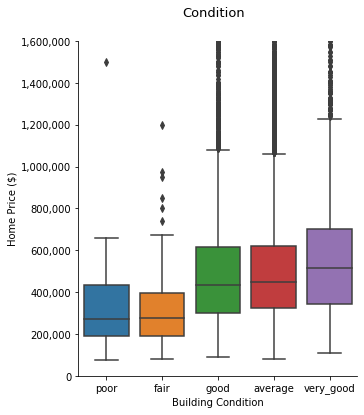

In [133]:
# chart for presentation slides

fig, ax = plt.subplots(figsize = (5,6))

order = df_processed.groupby(by=["condition_labels"])["price"].median().sort_values().index

sns.boxplot(data = df_processed, x= 'condition_labels', y = 'price', order=order)

ax.set(xlabel='Building Condition', ylabel='Home Price ($)')

ax.set_ylim([0, 1600000])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

sns.despine()

fig.suptitle('Condition', size=13)
fig.subplots_adjust(top=0.9)

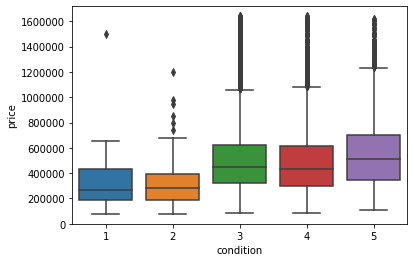

In [134]:
sns.boxplot(data = df_pp, x= 'condition', y = 'price')

In [135]:
condition_dummies_test_df = pd.concat([condition_dummies, df_processed['condition'], df_processed['price']], axis=1)
                                  

In [136]:
#Examine relationships between condition, new dummy variables for condition, and price
condition_dummies_test_df.corr().round(2)

,condition_average,condition_fair,condition_good,condition_very_good,condition,price
condition_average,1.00,-0.12,-0.81,-0.39,-0.86,0.01
condition_fair,-0.12,1.00,-0.05,-0.03,-0.20,-0.07
condition_good,-0.81,-0.05,1.00,-0.17,0.54,-0.03
condition_very_good,-0.39,-0.03,-0.17,1.00,0.71,0.06
condition,-0.86,-0.20,0.54,0.71,1.00,0.04
price,0.01,-0.07,-0.03,0.06,0.04,1.00


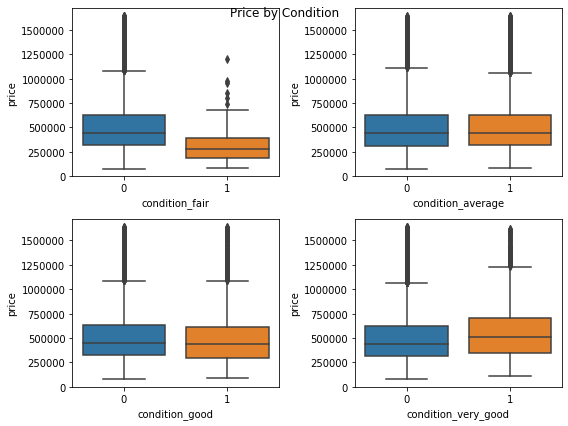

In [137]:
test_data = condition_dummies_test_df
fig, axes = plt.subplots(2,2, figsize=(8,6))
fig.suptitle('Price by Condition')
sns.boxplot(ax=axes[0,0], data=test_data, x='condition_fair', y='price')
sns.boxplot(ax=axes[0,1], data=test_data, x='condition_average', y='price')
sns.boxplot(ax=axes[1,0], data=test_data, x='condition_good', y='price')
sns.boxplot(ax=axes[1,1], data=test_data, x='condition_very_good', y='price')
plt.tight_layout()

- Condition: no clear ordering of condition values and higher price. 
- Looks like values of average, good, and very good are associated with higher price, with not much difference between them. Values of poor and fair are associated with lower price.

In [138]:
# ohe bedrooms
bedrooms_cat = 'bedrooms'
bedrooms_dummies = pd.get_dummies(df_processed.bedrooms, prefix=bedrooms_cat, drop_first=True)
bedrooms_dummies

,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
0,0,1,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,1,0,0
4,0,1,0,0,0
...,...,...,...,...,...
21592,0,1,0,0,0
21593,0,0,1,0,0
21594,1,0,0,0,0
21595,0,1,0,0,0


In [139]:
bedrooms_dummies_test_df = pd.concat([df_processed.price, df_processed.bedrooms, bedrooms_dummies], axis=1)

In [140]:
bedrooms_dummies_test_df.corr().round(2)

,price,bedrooms,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
price,1.00,0.31,-0.16,-0.18,0.22,0.16,0.06
bedrooms,0.31,1.00,-0.60,-0.36,0.52,0.53,0.32
bedrooms_2,-0.16,-0.60,1.00,-0.36,-0.26,-0.11,-0.04
bedrooms_3,-0.18,-0.36,-0.36,1.00,-0.63,-0.25,-0.10
bedrooms_4,0.22,0.52,-0.26,-0.63,1.00,-0.19,-0.07
bedrooms_5,0.16,0.53,-0.11,-0.25,-0.19,1.00,-0.03
bedrooms_6,0.06,0.32,-0.04,-0.10,-0.07,-0.03,1.00


In [141]:
# ohe bathrooms
bathrooms_cat = 'bathrooms'
bathrooms_dummies = pd.get_dummies(df_pp.bathrooms, prefix=bathrooms_cat, drop_first=True)
bathrooms_dummies

,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
21593,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
21594,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21595,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [142]:
bathrooms_dummies_test_df = pd.concat([df_pp.price, df_pp.bathrooms, bathrooms_dummies], axis=1)

In [143]:
bathrooms_dummies_test_df.corr()

,price,bathrooms,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25
price,1.000000,0.485649,-0.047494,-0.290069,0.009470,-0.100429,-0.083019,-0.061106,0.018212,0.085800,0.125988,0.106526,0.192399,0.237372,0.142875,0.124378,0.109221
bathrooms,0.485649,1.000000,-0.108354,-0.714557,-0.023949,-0.218568,-0.186412,-0.032064,0.081900,0.351587,0.230728,0.245648,0.263998,0.365503,0.181315,0.186791,0.151276
bathrooms_0.75,-0.047494,-0.108354,1.000000,-0.027537,-0.001204,-0.015789,-0.023931,-0.018465,-0.018973,-0.033904,-0.014049,-0.010929,-0.009253,-0.010569,-0.004462,-0.004001,-0.002868
bathrooms_1.0,-0.290069,-0.714557,-0.027537,1.000000,-0.009790,-0.128412,-0.194627,-0.150175,-0.154304,-0.275743,-0.114259,-0.088886,-0.075258,-0.085957,-0.036289,-0.032538,-0.023327
bathrooms_1.25,0.009470,-0.023949,-0.001204,-0.009790,1.000000,-0.005613,-0.008508,-0.006564,-0.006745,-0.012053,-0.004995,-0.003885,-0.003290,-0.003757,-0.001586,-0.001422,-0.001020
bathrooms_1.5,-0.100429,-0.218568,-0.015789,-0.128412,-0.005613,1.000000,-0.111596,-0.086108,-0.088476,-0.158108,-0.065515,-0.050966,-0.043152,-0.049286,-0.020807,-0.018657,-0.013375
bathrooms_1.75,-0.083019,-0.186412,-0.023931,-0.194627,-0.008508,-0.111596,1.000000,-0.130509,-0.134097,-0.239634,-0.099297,-0.077246,-0.065403,-0.074700,-0.031537,-0.028277,-0.020272
bathrooms_2.0,-0.061106,-0.032064,-0.018465,-0.150175,-0.006564,-0.086108,-0.130509,1.000000,-0.103470,-0.184902,-0.076618,-0.059604,-0.050465,-0.057639,-0.024334,-0.021819,-0.015642
bathrooms_2.25,0.018212,0.081900,-0.018973,-0.154304,-0.006745,-0.088476,-0.134097,-0.103470,1.000000,-0.189986,-0.078724,-0.061242,-0.051853,-0.059224,-0.025003,-0.022418,-0.016072
bathrooms_2.5,0.085800,0.351587,-0.033904,-0.275743,-0.012053,-0.158108,-0.239634,-0.184902,-0.189986,1.000000,-0.140682,-0.109441,-0.092661,-0.105834,-0.044680,-0.040062,-0.028721


In [144]:
# ohe city
city_dummies = pd.get_dummies(df_pp.city, prefix= 'city', drop_first=False)
city_dummies

,city_Auburn,city_Bellevue,city_Black_Diamond,city_Bothell,city_Carnation,city_Duvall,city_Enumclaw,city_Fall_City,city_Federal_Way,city_Issaquah,...,city_Medina,city_Mercer_Island,city_North_Bend,city_Redmond,city_Renton,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21595,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [145]:
#Since did not drop_first in ohe above, drop "city_Seattle" to make Seattle the reference city in the city dummy variable interpretation
city_dummies.drop(['city_Seattle'], axis=1, inplace=True)

In [146]:
city_dummies_test_df = pd.concat([df_pp.price, city_dummies], axis=1)
city_dummies_test_df.corr()

,price,city_Auburn,city_Bellevue,city_Black_Diamond,city_Bothell,city_Carnation,city_Duvall,city_Enumclaw,city_Fall_City,city_Federal_Way,...,city_Maple_Valley,city_Medina,city_Mercer_Island,city_North_Bend,city_Redmond,city_Renton,city_Sammamish,city_Snoqualmie,city_Vashon,city_Woodinville
price,1.000000,-0.176094,0.252449,-0.023004,-0.005262,-0.023074,-0.029588,-0.077378,0.004767,-0.164781,...,-0.092647,0.081343,0.207762,-0.031300,0.120912,-0.118843,0.153578,0.007299,-0.004358,0.060623
city_Auburn,-0.176094,1.000000,-0.053635,-0.014593,-0.020528,-0.016142,-0.020261,-0.022460,-0.012694,-0.041561,...,-0.035956,-0.006211,-0.022702,-0.021666,-0.046407,-0.060559,-0.041589,-0.025655,-0.015871,-0.031907
city_Bellevue,0.252449,-0.053635,1.000000,-0.017375,-0.024441,-0.019219,-0.024123,-0.026741,-0.015114,-0.049483,...,-0.042810,-0.007394,-0.027029,-0.025796,-0.055253,-0.072102,-0.049516,-0.030546,-0.018896,-0.037989
city_Black_Diamond,-0.023004,-0.014593,-0.017375,1.000000,-0.006650,-0.005229,-0.006563,-0.007276,-0.004112,-0.013463,...,-0.011648,-0.002012,-0.007354,-0.007019,-0.015033,-0.019618,-0.013472,-0.008311,-0.005141,-0.010336
city_Bothell,-0.005262,-0.020528,-0.024441,-0.006650,1.000000,-0.007356,-0.009232,-0.010235,-0.005785,-0.018939,...,-0.016385,-0.002830,-0.010345,-0.009873,-0.021147,-0.027596,-0.018952,-0.011691,-0.007232,-0.014540
city_Carnation,-0.023074,-0.016142,-0.019219,-0.005229,-0.007356,1.000000,-0.007260,-0.008048,-0.004549,-0.014892,...,-0.012884,-0.002225,-0.008135,-0.007764,-0.016629,-0.021700,-0.014902,-0.009193,-0.005687,-0.011433
city_Duvall,-0.029588,-0.020261,-0.024123,-0.006563,-0.009232,-0.007260,1.000000,-0.010101,-0.005709,-0.018692,...,-0.016171,-0.002793,-0.010210,-0.009745,-0.020872,-0.027237,-0.018705,-0.011539,-0.007138,-0.014350
city_Enumclaw,-0.077378,-0.022460,-0.026741,-0.007276,-0.010235,-0.008048,-0.010101,1.000000,-0.006329,-0.020721,...,-0.017926,-0.003096,-0.011318,-0.010802,-0.023137,-0.030193,-0.020735,-0.012791,-0.007913,-0.015908
city_Fall_City,0.004767,-0.012694,-0.015114,-0.004112,-0.005785,-0.004549,-0.005709,-0.006329,1.000000,-0.011712,...,-0.010132,-0.001750,-0.006397,-0.006105,-0.013077,-0.017065,-0.011720,-0.007230,-0.004472,-0.008991
city_Federal_Way,-0.164781,-0.041561,-0.049483,-0.013463,-0.018939,-0.014892,-0.018692,-0.020721,-0.011712,1.000000,...,-0.033172,-0.005730,-0.020945,-0.019989,-0.042814,-0.055871,-0.038369,-0.023669,-0.014643,-0.029437


In [147]:
df_processed.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'age', 'city', 'price_sqft', 'price_sqft_mean', 'basement', 'renovated',
       'condition_labels'],
      dtype='object')

In [148]:
df_processed = pd.concat([df_processed, levels_dummies, fl_number_dummies, grade_dummies, condition_dummies,
                         bedrooms_dummies, bathrooms_dummies, city_dummies], axis=1)
df_processed.shape

(21041, 87)

In [149]:
df_processed.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'age', 'city', 'price_sqft', 'price_sqft_mean', 'basement', 'renovated',
       'condition_labels', 'levels_two', 'levels_threeplus', 'floors_1.5',
       'floors_2', 'floors_2.5', 'floors_3', 'floors_3.5', 'grade_4',
       'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10',
       'grade_11', 'grade_12', 'condition_average', 'condition_fair',
       'condition_good', 'condition_very_good', 'bedrooms_2', 'bedrooms_3',
       'bedrooms_4', 'bedrooms_5', 'bedrooms_6', 'bathrooms_0.75',
       'bathrooms_1.0', 'bathrooms_1.25', 'bathrooms_1.5', 'bathrooms_1.75',
       'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.5', 'bathrooms_2.75',
       'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5', 'bathrooms_3.75',
       'bathrooms_4.0', '

In [150]:
# Create dummies list
dummies = ['levels_two', 'levels_threeplus', 'floors_1.5', 'floors_2',
       'floors_2.5', 'floors_3', 'floors_3.5','grade_4', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'condition_2',
       'condition_3', 'condition_4', 'condition_5', 'condition_average', 'condition_above',
        'bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6', 
        'bathrooms_0.75', 'bathrooms_1.0', 'bathrooms_1.25', 'bathrooms_1.5',
       'bathrooms_1.75', 'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.5',
       'bathrooms_2.75', 'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5',
       'bathrooms_3.75', 'bathrooms_4.0', 'bathrooms_4.25', 
        'city_Auburn', 'city_Bellevue', 'city_Black_Diamond', 'city_Bothell',
       'city_Carnation', 'city_Duvall', 'city_Enumclaw', 'city_Fall_City',
       'city_Federal_Way', 'city_Issaquah', 'city_Kenmore', 'city_Kent',
       'city_Kirkland', 'city_Maple_Valley', 'city_Medina',
       'city_Mercer_Island', 'city_North_Bend', 'city_Redmond', 'city_Renton',
       'city_Sammamish', 'city_Seattle', 'city_Snoqualmie', 'city_Vashon',
       'city_Woodinville']

In [151]:
# Re-examine correlations with price, and multicollinearity of variables (including new dummy variables)
# Multicollinearity of variables
data_test = df_processed

df=data_test.corr().round(2).abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

df.drop_duplicates(inplace=True)

In [152]:
df[(df.cc>.6) & (df.cc <1)].abs()

,cc
pairs,
"(floors_3, levels_threeplus)",0.90
"(sqft_above, sqft_living)",0.86
"(floors_2, levels_two)",0.83
"(basement, sqft_basement)",0.82
"(condition_good, condition_average)",0.81
"(sqft_living, sqft_living15)",0.75
"(floors_2, floors)",0.74
"(sqft_above, sqft_living15)",0.73
"(floors, levels_two)",0.72


- list returns many highly correlated pairs, since it includes continuous variables and their dummy variables. Linear regression models (below) will not include such correlated variable-dummy pairs.
- grade and sqft_living are most highly correlated with price and should be part of baseline model. However, these two variables are also highly correlated with eachother. Use grade dummies in model, in place of grade.
- bathrooms has next highest correlation with price, but it's lower at 49%.

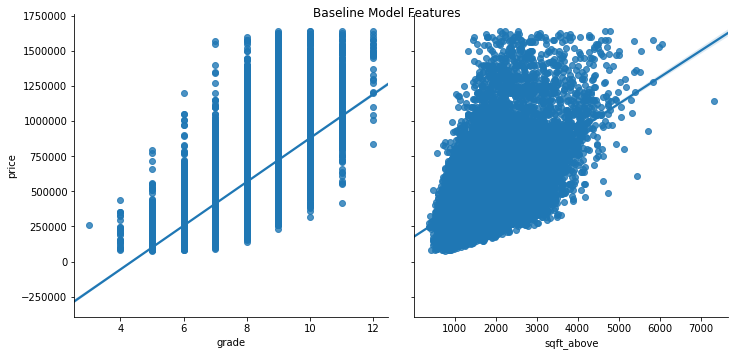

In [153]:
# Plot pairplots for price and grade, sqft_above
pp = sns.pairplot(data=df_pp,
            x_vars=['grade', 'sqft_above'],
            y_vars=['price'], 
            kind="reg",
            height = 5)
pp.fig.suptitle('Baseline Model Features')

plt.show()

## MODELING

### Baseline Model

- Build Baseline model:
    - This baseline model includes sqft_above and grade, which are two independent variables with highest correlations with price. Because sqft_above and grade are correlated somewhat highly at 73.5%, this model includes grade dummy variables and not the continuous grade variable.
    - Variables are not logged nor scaled at this point.

In [154]:
data = df_processed
X_data = data.drop(['price'], axis=1)

In [155]:
y = data.price 
X_model_baseline = data[['sqft_above', 'grade_9','grade_10','grade_11', 'grade_12']] 

In [156]:
X_model_baseline = sm.add_constant(X_model_baseline)

In [157]:
model_baseline = sm.OLS(y, X_model_baseline).fit()
model_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     3013.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:11:34   Log-Likelihood:            -2.8624e+05
No. Observations:               21041   AIC:                         5.725e+05
Df Residuals:                   21035   BIC:                         5.725e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.96e+05   3913.316     75.633      0.000    2.88e+05    3.04e+05
sqft_above    91.6965      2.387     38.413      0.000      87.018      96.375
grade_9     2.139e+05   4835.164     44.232      0.000    2.04e+05    2.23e+05
grade_10     3.53e+05   7428.746     47.514      0.000    3.38e+05    3.68e+05
grade_11      4.9e+05   1.35e+04     36.174      0.000    4.63e+05    5.17e+05
grade_12    7.114e+05    3.7e+04     19.243      0.000    6.39e+05    7.84e+05
==============================================================================
Omnibus:                     4184.482   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9314.835
Skew:                           1.145   Prob(JB):                         0.00
Kurtosis:                       5.319   Cond. No.                     5.20e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- r-squared: baseline model explains 41.7% of variance in dependent variable, price. There is room to improve this model through obtaining a higher r-squared in subsequent model iterations. Follow along for more!
- sqft_above and grade_9 - grade_12 are statistically significant. The other grade dummy variables (grade_4 - grade_8) are not statistically different from the dropped grade_3, so these were excluded from the baseline model.
- Coefficient signs are positive. 
    - For every unit increase in sqft_above, price increases by USD 91.7. 
    - A home with a given grade_9, grade_10, grade_11, and grade_12 would be worth more than a home with grades_4-grade_8 by USD 213.9k, USD 353k, USD 490k, and USD 711k, respectively.

### Selecting Best Combination of Features

In [158]:
#Model 2: Add structural features: bathrooms, floor dummies, basement. 
y = data.price 
X_model_2 = data[['sqft_above', 'grade_9','grade_10','grade_11', 'grade_12',
                  'bathrooms', 'levels_two', 'levels_threeplus', 'basement']]

In [159]:
model_2 = sm.OLS(y, sm.add_constant(X_model_2)).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     2323.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:11:34   Log-Likelihood:            -2.8466e+05
No. Observations:               21041   AIC:                         5.693e+05
Df Residuals:                   21031   BIC:                         5.694e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              1.65e+05   4622.938     35.690      0.000    1.56e+05    1.74e+05
sqft_above         118.3916      3.060     38.693      0.000     112.394     124.389
grade_9           1.804e+05   4522.710     39.887      0.000    1.72e+05    1.89e+05
grade_10           3.01e+05   6972.234     43.178      0.000    2.87e+05    3.15e+05
grade_11           4.21e+05   1.27e+04     33.169      0.000    3.96e+05    4.46e+05
grade_12          6.342e+05   3.44e+04     18.444      0.000    5.67e+05    7.02e+05
bathrooms         1.032e+04   2664.862      3.872      0.000    5095.311    1.55e+04
levels_two        1.534e+04   3229.948      4.750      0.000    9010.865    2.17e+04
levels_threeplus  9.348e+04   7255.577     12.884      0.000    7.93e+04    1.08e+05
basement          1.504e+05   3044.909     49.394      0.000    1.44e+05    1.56e+05
==============================================================================
Omnibus:                     4137.282   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10165.720
Skew:                           1.093   Prob(JB):                         0.00
Kurtosis:                       5.611   Cond. No.                     5.21e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [160]:
#Model 3: Add selling features: waterfront, sqft_lot, condition, renovated.
y = data.price 
X_model_3 = data[['sqft_above', 'grade_9','grade_10','grade_11', 'grade_12',
                  'bathrooms', 'levels_two', 'levels_threeplus', 'basement',
                 'waterfront', 'sqft_lot','condition', 'renovated']]

In [161]:
model_3 = sm.OLS(y, sm.add_constant(X_model_3)).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     1835.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:11:34   Log-Likelihood:            -2.8395e+05
No. Observations:               21041   AIC:                         5.679e+05
Df Residuals:                   21027   BIC:                         5.680e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3.582e+04   8187.751     -4.375      0.000   -5.19e+04   -1.98e+04
sqft_above         119.7175      2.991     40.027      0.000     113.855     125.580
grade_9           1.839e+05   4376.046     42.031      0.000    1.75e+05    1.93e+05
grade_10          3.103e+05   6748.043     45.977      0.000    2.97e+05    3.23e+05
grade_11          4.347e+05   1.23e+04     35.404      0.000    4.11e+05    4.59e+05
grade_12          6.241e+05   3.33e+04     18.768      0.000    5.59e+05    6.89e+05
bathrooms         1.201e+04   2578.870      4.658      0.000    6958.628    1.71e+04
levels_two        2.352e+04   3158.056      7.447      0.000    1.73e+04    2.97e+04
levels_threeplus  1.127e+05   7066.368     15.951      0.000    9.89e+04    1.27e+05
basement          1.405e+05   2955.754     47.530      0.000    1.35e+05    1.46e+05
waterfront        3.316e+05      2e+04     16.585      0.000    2.92e+05    3.71e+05
sqft_lot            -0.1074      0.032     -3.315      0.001      -0.171      -0.044
condition         5.561e+04   1928.776     28.829      0.000    5.18e+04    5.94e+04
renovated         1.325e+05   6882.506     19.257      0.000    1.19e+05    1.46e+05
==============================================================================
Omnibus:                     3643.252   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8788.514
Skew:                           0.978   Prob(JB):                         0.00
Kurtosis:                       5.490   Cond. No.                     1.13e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [162]:
#Model 4: Add location-related variables--sqft_lot15, city dummy variables.

y = data.price 
X_model_4 = data[['sqft_above', 'grade_9','grade_10','grade_11', 'grade_12',
                  'bathrooms', 'levels_two', 'levels_threeplus', 'basement',
                 'waterfront', 'sqft_lot','condition', 'renovated','sqft_lot15',
                  'city_Auburn', 'city_Bellevue', 'city_Black_Diamond', 'city_Bothell', 
                  'city_Carnation', 'city_Duvall', 'city_Enumclaw', 'city_Fall_City', 
                  'city_Federal_Way', 'city_Issaquah', 'city_Kenmore', 'city_Kent', 
                  'city_Kirkland', 'city_Maple_Valley', 'city_Medina', 'city_Mercer_Island', 
                  'city_North_Bend', 'city_Redmond', 'city_Renton', 'city_Sammamish', 
                  'city_Snoqualmie', 'city_Vashon', 'city_Woodinville']]

In [163]:
model_4 = sm.OLS(y, sm.add_constant(X_model_4)).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     1285.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:11:34   Log-Likelihood:            -2.7948e+05
No. Observations:               21041   AIC:                         5.590e+05
Df Residuals:                   21003   BIC:                         5.593e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.201e+04   6698.136      3.287      0.001    8884.923    3.51e+04
sqft_above           131.4970      2.498     52.638      0.000     126.600     136.393
grade_9              1.38e+05   3580.651     38.554      0.000    1.31e+05    1.45e+05
grade_10            2.271e+05   5586.287     40.654      0.000    2.16e+05    2.38e+05
grade_11            3.363e+05      1e+04     33.571      0.000    3.17e+05    3.56e+05
grade_12            4.619e+05    2.7e+04     17.108      0.000    4.09e+05    5.15e+05
bathrooms           2.813e+04   2130.886     13.199      0.000    2.39e+04    3.23e+04
levels_two          1.922e+04   2653.093      7.246      0.000     1.4e+04    2.44e+04
levels_threeplus    4.803e+04   5951.879      8.070      0.000    3.64e+04    5.97e+04
basement            9.775e+04   2480.495     39.407      0.000    9.29e+04    1.03e+05
waterfront          3.365e+05   1.65e+04     20.351      0.000    3.04e+05    3.69e+05
sqft_lot               0.2390      0.037      6.506      0.000       0.167       0.311
condition           4.717e+04   1588.558     29.694      0.000    4.41e+04    5.03e+04
renovated           9.397e+04   5610.303     16.749      0.000     8.3e+04    1.05e+05
sqft_lot15            -0.0299      0.055     -0.548      0.584      -0.137       0.077
city_Auburn         -2.44e+05   5103.478    -47.808      0.000   -2.54e+05   -2.34e+05
city_Bellevue       1.184e+05   4492.343     26.352      0.000     1.1e+05    1.27e+05
city_Black_Diamond -1.768e+05   1.45e+04    -12.187      0.000   -2.05e+05   -1.48e+05
city_Bothell        -9.26e+04   1.04e+04     -8.934      0.000   -1.13e+05   -7.23e+04
city_Carnation     -1.307e+05   1.33e+04     -9.788      0.000   -1.57e+05   -1.04e+05
city_Duvall        -1.385e+05   1.06e+04    -13.064      0.000   -1.59e+05   -1.18e+05
city_Enumclaw      -2.187e+05   9712.892    -22.515      0.000   -2.38e+05      -2e+05
city_Fall_City     -7.178e+04   1.68e+04     -4.278      0.000   -1.05e+05   -3.89e+04
city_Federal_Way   -2.429e+05   5414.446    -44.860      0.000   -2.54e+05   -2.32e+05
city_Issaquah      -4.339e+04   5676.480     -7.643      0.000   -5.45e+04   -3.23e+04
city_Kenmore       -8.524e+04   8661.607     -9.842      0.000   -1.02e+05   -6.83e+04
city_Kent          -2.309e+05   4525.426    -51.014      0.000    -2.4e+05   -2.22e+05
city_Kirkland       2.632e+04   4975.525      5.290      0.000    1.66e+04    3.61e+04
city_Maple_Valley   -2.04e+05   6284.368    -32.460      0.000   -2.16e+05   -1.92e+05
city_Medina         6.053e+05   3.36e+04     18.026      0.000    5.39e+05    6.71e+05
city_Mercer_Island  2.544e+05   9533.157     26.691      0.000    2.36e+05    2.73e+05
city_North_Bend    -1.246e+05   9913.873    -12.564      0.000   -1.44e+05   -1.05e+05
city_Redmond        7716.4703   5088.3

In [164]:
# Model 5: Drop non-statistically significant variables: sqft_lot15, city_Redmond. Drop condition to reduce multicollinearity.
y = data.price 
X_model_5 = data[['sqft_above', 'grade_9','grade_10','grade_11', 'grade_12',
                  'bathrooms', 'levels_two', 'basement',
                 'waterfront', 'sqft_lot', 'renovated',
                  'city_Auburn', 'city_Bellevue', 'city_Black_Diamond', 'city_Bothell', 
                  'city_Duvall', 'city_Enumclaw', 'city_Fall_City', 
                  'city_Federal_Way', 'city_Issaquah', 'city_Kenmore', 'city_Kent', 
                  'city_Kirkland', 'city_Maple_Valley', 'city_Medina', 'city_Mercer_Island', 
                  'city_North_Bend', 'city_Renton', 'city_Sammamish', 
                  'city_Snoqualmie', 'city_Vashon', 'city_Woodinville']]

In [165]:
model_5 = sm.OLS(y, sm.add_constant(X_model_5)).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     1386.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:11:34   Log-Likelihood:            -2.7998e+05
No. Observations:               21041   AIC:                         5.600e+05
Df Residuals:                   21008   BIC:                         5.603e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                1.87e+05   3738.572     50.019      0.000     1.8e+05    1.94e+05
sqft_above           131.9586      2.525     52.270      0.000     127.010     136.907
grade_9             1.337e+05   3661.594     36.510      0.000    1.27e+05    1.41e+05
grade_10            2.196e+05   5710.000     38.452      0.000    2.08e+05    2.31e+05
grade_11            3.245e+05   1.02e+04     31.674      0.000    3.04e+05    3.45e+05
grade_12            4.497e+05   2.76e+04     16.275      0.000    3.96e+05    5.04e+05
bathrooms           2.914e+04   2101.183     13.867      0.000     2.5e+04    3.33e+04
levels_two          7420.9333   2554.554      2.905      0.004    2413.810    1.24e+04
basement            1.013e+05   2446.053     41.430      0.000    9.65e+04    1.06e+05
waterfront          3.416e+05   1.69e+04     20.176      0.000    3.08e+05    3.75e+05
sqft_lot               0.1759      0.028      6.235      0.000       0.121       0.231
renovated            8.28e+04   5722.056     14.470      0.000    7.16e+04     9.4e+04
city_Auburn        -2.437e+05   5123.344    -47.567      0.000   -2.54e+05   -2.34e+05
city_Bellevue        1.28e+05   4464.041     28.668      0.000    1.19e+05    1.37e+05
city_Black_Diamond -1.671e+05   1.48e+04    -11.305      0.000   -1.96e+05   -1.38e+05
city_Bothell       -1.024e+05   1.06e+04     -9.694      0.000   -1.23e+05   -8.17e+04
city_Duvall        -1.514e+05   1.08e+04    -14.069      0.000   -1.72e+05    -1.3e+05
city_Enumclaw      -2.021e+05   9823.505    -20.574      0.000   -2.21e+05   -1.83e+05
city_Fall_City      -7.62e+04    1.7e+04     -4.473      0.000    -1.1e+05   -4.28e+04
city_Federal_Way   -2.476e+05   5459.992    -45.341      0.000   -2.58e+05   -2.37e+05
city_Issaquah      -4.515e+04   5732.765     -7.876      0.000   -5.64e+04   -3.39e+04
city_Kenmore       -9.272e+04   8816.234    -10.517      0.000    -1.1e+05   -7.54e+04
city_Kent          -2.286e+05   4526.596    -50.511      0.000   -2.38e+05    -2.2e+05
city_Kirkland       2.553e+04   5004.386      5.101      0.000    1.57e+04    3.53e+04
city_Maple_Valley  -2.113e+05   6327.448    -33.396      0.000   -2.24e+05   -1.99e+05
city_Medina         6.162e+05   3.44e+04     17.931      0.000    5.49e+05    6.84e+05
city_Mercer_Island  2.757e+05   9671.463     28.508      0.000    2.57e+05    2.95e+05
city_North_Bend    -1.348e+05   1.01e+04    -13.373      0.000   -1.55e+05   -1.15e+05
city_Renton         -1.63e+05   4021.718    -40.538      0.000   -1.71e+05   -1.55e+05
city_Sammamish     -4.212e+04   5697.164     -7.393      0.000   -5.33e+04    -3.1e+04
city_Snoqualmie    -1.334e+05   8640.754    -15.434      0.000    -1.5e+05   -1.16e+05
city_Vashon        -1.082e+05   1.41e+04     -7.697      0.000   -1.36e+05   -8.06e+04
city_Woodinville   -7.205e+04   7056.7

In [166]:
# Model 6: Replace bathrooms with bathroom dummies
y = data.price 
X_model_6 = data[['sqft_above', 'grade_9','grade_10','grade_11', 'grade_12',
                  'bathrooms_1.0','bathrooms_1.25', 'bathrooms_1.5',
                  'bathrooms_1.75', 'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.5',
                  'bathrooms_2.75', 'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5',
                  'bathrooms_3.75', 'bathrooms_4.0', 'bathrooms_4.25', 
                  'levels_two', 'basement',
                 'waterfront', 'sqft_lot','renovated',
                  'city_Auburn', 'city_Bellevue', 'city_Black_Diamond', 'city_Bothell', 
                  'city_Duvall', 'city_Enumclaw', 'city_Fall_City', 
                  'city_Federal_Way', 'city_Issaquah', 'city_Kenmore', 'city_Kent', 
                  'city_Kirkland', 'city_Maple_Valley', 'city_Medina', 'city_Mercer_Island', 
                  'city_North_Bend', 'city_Renton', 'city_Sammamish', 
                  'city_Snoqualmie', 'city_Vashon', 'city_Woodinville']]

In [167]:
model_6 = sm.OLS(y, sm.add_constant(X_model_6)).fit()
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     991.5
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:11:34   Log-Likelihood:            -2.7993e+05
No. Observations:               21041   AIC:                         5.600e+05
Df Residuals:                   20995   BIC:                         5.603e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                1.82e+05    1.7e+04     10.703      0.000    1.49e+05    2.15e+05
sqft_above           131.7237      2.530     52.064      0.000     126.765     136.683
grade_9             1.351e+05   3690.474     36.604      0.000    1.28e+05    1.42e+05
grade_10            2.176e+05   5814.460     37.422      0.000    2.06e+05    2.29e+05
grade_11            3.177e+05   1.05e+04     30.320      0.000    2.97e+05    3.38e+05
grade_12            4.395e+05   2.78e+04     15.784      0.000    3.85e+05    4.94e+05
bathrooms_1.0       3.315e+04    1.7e+04      1.949      0.051    -182.154    6.65e+04
bathrooms_1.25      1.107e+05   5.13e+04      2.158      0.031    1.02e+04    2.11e+05
bathrooms_1.5       4.756e+04   1.73e+04      2.745      0.006    1.36e+04    8.15e+04
bathrooms_1.75      6.502e+04   1.71e+04      3.795      0.000    3.14e+04    9.86e+04
bathrooms_2.0       6.784e+04   1.72e+04      3.933      0.000     3.4e+04    1.02e+05
bathrooms_2.25      7.013e+04   1.73e+04      4.046      0.000    3.62e+04    1.04e+05
bathrooms_2.5       6.259e+04   1.72e+04      3.634      0.000    2.88e+04    9.63e+04
bathrooms_2.75      9.511e+04   1.77e+04      5.384      0.000    6.05e+04     1.3e+05
bathrooms_3.0       8.658e+04    1.8e+04      4.811      0.000    5.13e+04    1.22e+05
bathrooms_3.25      1.199e+05   1.84e+04      6.502      0.000    8.38e+04    1.56e+05
bathrooms_3.5       1.045e+05   1.83e+04      5.707      0.000    6.86e+04     1.4e+05
bathrooms_3.75      1.606e+05   2.19e+04      7.325      0.000    1.18e+05    2.04e+05
bathrooms_4.0       1.162e+05   2.29e+04      5.069      0.000    7.13e+04    1.61e+05
bathrooms_4.25      1.636e+05   2.72e+04      6.023      0.000     1.1e+05    2.17e+05
levels_two          1.186e+04   2612.374      4.540      0.000    6740.753     1.7e+04
basement             9.89e+04   2478.446     39.906      0.000     9.4e+04    1.04e+05
waterfront          3.419e+05   1.69e+04     20.181      0.000    3.09e+05    3.75e+05
sqft_lot               0.1656      0.028      5.874      0.000       0.110       0.221
renovated           8.041e+04   5729.033     14.036      0.000    6.92e+04    9.16e+04
city_Auburn        -2.415e+05   5129.110    -47.088      0.000   -2.52e+05   -2.31e+05
city_Bellevue       1.291e+05   4486.260     28.774      0.000     1.2e+05    1.38e+05
city_Black_Diamond -1.656e+05   1.48e+04    -11.220      0.000   -1.95e+05   -1.37e+05
city_Bothell        -1.01e+05   1.06e+04     -9.574      0.000   -1.22e+05   -8.03e+04
city_Duvall        -1.492e+05   1.07e+04    -13.879      0.000    -1.7e+05   -1.28e+05
city_Enumclaw      -2.014e+05   9811.106    -20.528      0.000   -2.21e+05   -1.82e+05
city_Fall_City     -7.652e+04    1.7e+04     -4.497      0.000    -1.1e+05   -4.32e+04
city_Federal_Way   -2.462e+05   5468.0

In [168]:
# Model 7: Drop bathroom dummies that are not statistically significant (bathrooms_1.0). Add statistically significant condition_good and condition_very_good.
y = data.price 
X_model_7 = data[['sqft_above', 'grade_8','grade_9','grade_10','grade_11', 'grade_12',
                  'bathrooms_1.25', 'bathrooms_1.5', 'bathrooms_1.75', 'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.5',
                  'bathrooms_2.75', 'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5',
                  'bathrooms_3.75', 'bathrooms_4.0', 'bathrooms_4.25', 
                  'levels_two', 'basement',
                  'waterfront', 'sqft_lot', 'renovated', 'condition_good', 'condition_very_good',
                  'city_Auburn', 'city_Bellevue', 'city_Black_Diamond', 'city_Bothell', 
                  'city_Duvall', 'city_Enumclaw', 'city_Fall_City', 
                  'city_Federal_Way', 'city_Issaquah', 'city_Kenmore', 'city_Kent', 
                  'city_Kirkland', 'city_Maple_Valley', 'city_Medina', 'city_Mercer_Island', 
                  'city_North_Bend', 'city_Renton', 'city_Sammamish', 
                  'city_Snoqualmie', 'city_Vashon', 'city_Woodinville']]

In [169]:
model_7 = sm.OLS(y, sm.add_constant(X_model_7)).fit()
model_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     1072.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:11:34   Log-Likelihood:            -2.7905e+05
No. Observations:               21041   AIC:                         5.582e+05
Df Residuals:                   20993   BIC:                         5.586e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.076e+05   3681.394     56.400      0.000       2e+05    2.15e+05
sqft_above            114.6342      2.490     46.042      0.000     109.754     119.514
grade_8              8.423e+04   2651.372     31.768      0.000     7.9e+04    8.94e+04
grade_9              2.006e+05   4043.796     49.609      0.000    1.93e+05    2.09e+05
grade_10             2.975e+05   6041.995     49.245      0.000    2.86e+05    3.09e+05
grade_11             4.116e+05   1.04e+04     39.570      0.000    3.91e+05    4.32e+05
grade_12             5.412e+05   2.69e+04     20.143      0.000    4.89e+05    5.94e+05
bathrooms_1.25       4.883e+04   4.66e+04      1.048      0.294   -4.25e+04     1.4e+05
bathrooms_1.5        6205.9158   4385.580      1.415      0.157   -2390.159    1.48e+04
bathrooms_1.75       1.467e+04   3639.137      4.031      0.000    7537.658    2.18e+04
bathrooms_2.0        1.784e+04   4091.455      4.361      0.000    9822.782    2.59e+04
bathrooms_2.25       9042.3397   4410.145      2.050      0.040     398.116    1.77e+04
bathrooms_2.5        4988.4490   3989.249      1.250      0.211   -2830.786    1.28e+04
bathrooms_2.75       3.053e+04   5443.316      5.609      0.000    1.99e+04    4.12e+04
bathrooms_3.0         3.05e+04   6335.633      4.815      0.000    1.81e+04    4.29e+04
bathrooms_3.25       5.827e+04   7446.913      7.825      0.000    4.37e+04    7.29e+04
bathrooms_3.5        5.219e+04   7090.524      7.360      0.000    3.83e+04    6.61e+04
bathrooms_3.75       1.091e+05   1.35e+04      8.067      0.000    8.26e+04    1.36e+05
bathrooms_4.0        6.619e+04    1.5e+04      4.421      0.000    3.68e+04    9.55e+04
bathrooms_4.25       1.161e+05   2.05e+04      5.675      0.000     7.6e+04    1.56e+05
levels_two           1.442e+04   2510.099      5.743      0.000    9495.527    1.93e+04
basement             8.812e+04   2391.558     36.846      0.000    8.34e+04    9.28e+04
waterfront            3.31e+05   1.62e+04     20.397      0.000    2.99e+05    3.63e+05
sqft_lot                0.1570      0.027      5.805      0.000       0.104       0.210
renovated            9.258e+04   5509.717     16.802      0.000    8.18e+04    1.03e+05
condition_good        4.69e+04   2361.542     19.861      0.000    4.23e+04    5.15e+04
condition_very_good  1.028e+05   3750.582     27.404      0.000    9.54e+04     1.1e+05
city_Auburn         -2.346e+05   4935.639    -47.541      0.000   -2.44e+05   -2.25e+05
city_Bellevue        1.089e+05   4353.805     25.004      0.000       1e+05    1.17e+05
city_Black_Diamond  -1.612e+05   1.42e+04    -11.381      0.000   -1.89e+05   -1.33e+05
city_Bothell        -8.867e+04   1.01e+04     -8.760      0.000   -1.09e+05   -6.88e+04
city_Duvall         -1.276e+05   1.03e+04    -12.365      0.000   -1.48e+05   -1.07e+05
cit

In [170]:
# Model 8: Drop bathrooms_1.25, bathrooms_1.5, bathrooms_2.5, which are statistically insignificant.
y = data.price 
X_model_8 = data[['sqft_above', 'grade_8','grade_9','grade_10','grade_11', 'grade_12',
                  'bathrooms_1.75', 'bathrooms_2.0', 'bathrooms_2.25',
                  'bathrooms_2.75', 'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5',
                  'bathrooms_3.75', 'bathrooms_4.0', 'bathrooms_4.25', 
                  'levels_two', 'basement',
                  'waterfront', 'sqft_lot', 'renovated', 'condition_good', 'condition_very_good',
                  'city_Auburn', 'city_Bellevue', 'city_Black_Diamond', 'city_Bothell', 
                  'city_Duvall', 'city_Enumclaw', 'city_Fall_City', 
                  'city_Federal_Way', 'city_Issaquah', 'city_Kenmore', 'city_Kent', 
                  'city_Kirkland', 'city_Maple_Valley', 'city_Medina', 'city_Mercer_Island', 
                  'city_North_Bend', 'city_Renton', 'city_Sammamish', 
                  'city_Snoqualmie', 'city_Vashon', 'city_Woodinville']]

In [171]:
model_8 = sm.OLS(y, sm.add_constant(X_model_8)).fit()
model_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     1144.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:11:34   Log-Likelihood:            -2.7905e+05
No. Observations:               21041   AIC:                         5.582e+05
Df Residuals:                   20996   BIC:                         5.586e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.085e+05   3607.714     57.797      0.000    2.01e+05    2.16e+05
sqft_above            115.5478      2.349     49.192      0.000     110.944     120.152
grade_8              8.504e+04   2550.778     33.337      0.000       8e+04       9e+04
grade_9              2.011e+05   3998.245     50.295      0.000    1.93e+05    2.09e+05
grade_10             2.976e+05   6033.399     49.328      0.000    2.86e+05    3.09e+05
grade_11             4.114e+05   1.04e+04     39.587      0.000    3.91e+05    4.32e+05
grade_12             5.405e+05   2.69e+04     20.120      0.000    4.88e+05    5.93e+05
bathrooms_1.75       1.155e+04   2997.949      3.851      0.000    5669.057    1.74e+04
bathrooms_2.0         1.47e+04   3514.908      4.182      0.000    7808.288    2.16e+04
bathrooms_2.25       5158.8871   3484.736      1.480      0.139   -1671.463     1.2e+04
bathrooms_2.75       2.622e+04   4487.497      5.844      0.000    1.74e+04     3.5e+04
bathrooms_3.0         2.62e+04   5531.738      4.736      0.000    1.54e+04     3.7e+04
bathrooms_3.25        5.35e+04   6569.774      8.144      0.000    4.06e+04    6.64e+04
bathrooms_3.5        4.714e+04   6012.972      7.840      0.000    3.54e+04    5.89e+04
bathrooms_3.75        1.04e+05    1.3e+04      8.014      0.000    7.86e+04    1.29e+05
bathrooms_4.0        6.107e+04   1.45e+04      4.218      0.000    3.27e+04    8.94e+04
bathrooms_4.25       1.106e+05      2e+04      5.521      0.000    7.13e+04     1.5e+05
levels_two           1.499e+04   2464.153      6.081      0.000    1.02e+04    1.98e+04
basement             8.907e+04   2277.733     39.106      0.000    8.46e+04    9.35e+04
waterfront           3.314e+05   1.62e+04     20.441      0.000       3e+05    3.63e+05
sqft_lot                0.1552      0.027      5.748      0.000       0.102       0.208
renovated             9.24e+04   5508.889     16.774      0.000    8.16e+04    1.03e+05
condition_good       4.672e+04   2346.953     19.907      0.000    4.21e+04    5.13e+04
condition_very_good  1.027e+05   3749.764     27.388      0.000    9.53e+04     1.1e+05
city_Auburn         -2.342e+05   4914.753    -47.645      0.000   -2.44e+05   -2.25e+05
city_Bellevue        1.093e+05   4341.952     25.175      0.000    1.01e+05    1.18e+05
city_Black_Diamond  -1.609e+05   1.42e+04    -11.359      0.000   -1.89e+05   -1.33e+05
city_Bothell        -8.824e+04   1.01e+04     -8.724      0.000   -1.08e+05   -6.84e+04
city_Duvall          -1.27e+05   1.03e+04    -12.328      0.000   -1.47e+05   -1.07e+05
city_Enumclaw       -2.088e+05   9420.368    -22.169      0.000   -2.27e+05    -1.9e+05
city_Fall_City      -6.256e+04   1.63e+04     -3.834      0.000   -9.45e+04   -3.06e+04
city_Federal_Way    -2.447e+05   5244.939    -46.646      0.000   -2.55e+05   -2.34e+05
cit

In [172]:
# Model 9: Drop bathrooms_2.25, which is statistically insignificant.
y = data.price 
X_model_9 = data[['sqft_above', 'grade_8','grade_9','grade_10','grade_11', 'grade_12',
                  'bathrooms_1.75', 'bathrooms_2.0', 
                  'bathrooms_2.75', 'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5',
                  'bathrooms_3.75', 'bathrooms_4.0', 'bathrooms_4.25',
                  'levels_two', 'levels_threeplus', 'basement',
                  'waterfront', 'sqft_lot', 'renovated', 'condition_good', 'condition_very_good',
                  'city_Auburn', 'city_Bellevue', 'city_Black_Diamond', 'city_Bothell', 
                  'city_Duvall', 'city_Enumclaw', 'city_Fall_City', 
                  'city_Federal_Way', 'city_Issaquah', 'city_Kenmore', 'city_Kent', 
                  'city_Kirkland', 'city_Maple_Valley', 'city_Medina', 'city_Mercer_Island', 
                  'city_North_Bend', 'city_Renton', 'city_Sammamish', 
                  'city_Snoqualmie', 'city_Vashon', 'city_Woodinville']]

In [173]:
X_model_9 = sm.add_constant(X_model_9)

In [174]:
model_9 = sm.OLS(y, X_model_9).fit()
model_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     1146.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:11:34   Log-Likelihood:            -2.7904e+05
No. Observations:               21041   AIC:                         5.582e+05
Df Residuals:                   20996   BIC:                         5.585e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.056e+05   3660.687     56.158      0.000    1.98e+05    2.13e+05
sqft_above            115.2397      2.347     49.094      0.000     110.639     119.841
grade_8              8.291e+04   2589.738     32.015      0.000    7.78e+04     8.8e+04
grade_9               1.99e+05   4018.922     49.519      0.000    1.91e+05    2.07e+05
grade_10             2.959e+05   6038.548     48.997      0.000    2.84e+05    3.08e+05
grade_11             4.095e+05   1.04e+04     39.414      0.000    3.89e+05     4.3e+05
grade_12             5.403e+05   2.68e+04     20.126      0.000    4.88e+05    5.93e+05
bathrooms_1.75       1.155e+04   2937.111      3.931      0.000    5788.882    1.73e+04
bathrooms_2.0         1.41e+04   3468.499      4.064      0.000    7297.963    2.09e+04
bathrooms_2.75       2.535e+04   4423.744      5.731      0.000    1.67e+04     3.4e+04
bathrooms_3.0         2.39e+04   5488.526      4.354      0.000    1.31e+04    3.47e+04
bathrooms_3.25       5.022e+04   6542.123      7.677      0.000    3.74e+04     6.3e+04
bathrooms_3.5        4.482e+04   5969.931      7.508      0.000    3.31e+04    5.65e+04
bathrooms_3.75       1.012e+05    1.3e+04      7.806      0.000    7.58e+04    1.27e+05
bathrooms_4.0        5.769e+04   1.45e+04      3.990      0.000    2.93e+04     8.6e+04
bathrooms_4.25       1.075e+05      2e+04      5.375      0.000    6.83e+04    1.47e+05
levels_two           1.874e+04   2580.910      7.260      0.000    1.37e+04    2.38e+04
levels_threeplus     2.775e+04   5761.906      4.816      0.000    1.65e+04     3.9e+04
basement             9.137e+04   2277.362     40.120      0.000    8.69e+04    9.58e+04
waterfront           3.311e+05   1.62e+04     20.431      0.000    2.99e+05    3.63e+05
sqft_lot                0.1623      0.027      6.007      0.000       0.109       0.215
renovated            9.293e+04   5507.352     16.875      0.000    8.21e+04    1.04e+05
condition_good       4.789e+04   2353.471     20.348      0.000    4.33e+04    5.25e+04
condition_very_good  1.037e+05   3753.319     27.636      0.000    9.64e+04    1.11e+05
city_Auburn         -2.323e+05   4926.126    -47.155      0.000   -2.42e+05   -2.23e+05
city_Bellevue        1.122e+05   4363.142     25.721      0.000    1.04e+05    1.21e+05
city_Black_Diamond  -1.601e+05   1.42e+04    -11.309      0.000   -1.88e+05   -1.32e+05
city_Bothell        -8.562e+04   1.01e+04     -8.463      0.000   -1.05e+05   -6.58e+04
city_Duvall         -1.252e+05   1.03e+04    -12.149      0.000   -1.45e+05   -1.05e+05
city_Enumclaw       -2.073e+05   9419.969    -22.007      0.000   -2.26e+05   -1.89e+05
city_Fall_City      -6.024e+04   1.63e+04     -3.692      0.000   -9.22e+04   -2.83e+04
city_Federal_Way    -2.419e+05   5260.793    -45.986      0.000   -2.52e+05   -2.32e+05
cit

#### Log transformation

In [175]:
data['price_log'] = np.log(data.price)
data['sqft_above_log'] = np.log(data.sqft_above)

In [176]:
#Model 10:  Log transform price. Use independent variables in Model9.
y_log = data.price_log
X_model_10 = data[['sqft_above', 'grade_8','grade_9','grade_10','grade_11', 'grade_12',
                  'bathrooms_1.75', 'bathrooms_2.0', 
                  'bathrooms_2.75', 'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5',
                  'bathrooms_3.75', 'bathrooms_4.0', 'bathrooms_4.25', 
                  'levels_two', 'basement',
                  'waterfront', 'sqft_lot', 'renovated', 'condition_good', 'condition_very_good',
                  'city_Auburn', 'city_Bellevue', 'city_Black_Diamond', 'city_Bothell', 
                  'city_Duvall', 'city_Enumclaw', 'city_Fall_City', 
                  'city_Federal_Way', 'city_Issaquah', 'city_Kenmore', 'city_Kent', 
                  'city_Kirkland', 'city_Maple_Valley', 'city_Medina', 'city_Mercer_Island', 
                  'city_North_Bend', 'city_Renton', 'city_Sammamish', 
                  'city_Snoqualmie', 'city_Vashon', 'city_Woodinville']]


In [177]:
X_model_10 = sm.add_constant(X_model_10)

In [178]:
model_10 = sm.OLS(y, X_model_10).fit()
model_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     1171.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:11:34   Log-Likelihood:            -2.7905e+05
No. Observations:               21041   AIC:                         5.582e+05
Df Residuals:                   20997   BIC:                         5.585e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.086e+05   3606.723     57.849      0.000    2.02e+05    2.16e+05
sqft_above            115.7037      2.347     49.307      0.000     111.104     120.303
grade_8               8.54e+04   2538.935     33.636      0.000    8.04e+04    9.04e+04
grade_9              2.011e+05   3998.326     50.288      0.000    1.93e+05    2.09e+05
grade_10             2.975e+05   6032.690     49.308      0.000    2.86e+05    3.09e+05
grade_11             4.111e+05   1.04e+04     39.566      0.000    3.91e+05    4.32e+05
grade_12             5.401e+05   2.69e+04     20.107      0.000    4.87e+05    5.93e+05
bathrooms_1.75       1.062e+04   2932.382      3.622      0.000    4873.851    1.64e+04
bathrooms_2.0        1.387e+04   3470.006      3.996      0.000    7066.309    2.07e+04
bathrooms_2.75       2.513e+04   4425.835      5.677      0.000    1.65e+04    3.38e+04
bathrooms_3.0        2.514e+04   5485.386      4.583      0.000    1.44e+04    3.59e+04
bathrooms_3.25       5.243e+04   6529.577      8.029      0.000    3.96e+04    6.52e+04
bathrooms_3.5        4.605e+04   5967.661      7.716      0.000    3.44e+04    5.77e+04
bathrooms_3.75        1.03e+05    1.3e+04      7.943      0.000    7.76e+04    1.28e+05
bathrooms_4.0        5.995e+04   1.45e+04      4.146      0.000    3.16e+04    8.83e+04
bathrooms_4.25       1.094e+05      2e+04      5.466      0.000    7.02e+04    1.49e+05
levels_two           1.502e+04   2464.112      6.096      0.000    1.02e+04    1.99e+04
basement             8.961e+04   2249.034     39.842      0.000    8.52e+04     9.4e+04
waterfront           3.313e+05   1.62e+04     20.433      0.000       3e+05    3.63e+05
sqft_lot                0.1554      0.027      5.756      0.000       0.102       0.208
renovated            9.235e+04   5508.929     16.764      0.000    8.16e+04    1.03e+05
condition_good       4.686e+04   2345.080     19.984      0.000    4.23e+04    5.15e+04
condition_very_good  1.027e+05   3749.750     27.400      0.000    9.54e+04     1.1e+05
city_Auburn         -2.341e+05   4914.616    -47.630      0.000   -2.44e+05   -2.24e+05
city_Bellevue        1.097e+05   4333.893     25.313      0.000    1.01e+05    1.18e+05
city_Black_Diamond   -1.61e+05   1.42e+04    -11.368      0.000   -1.89e+05   -1.33e+05
city_Bothell        -8.785e+04   1.01e+04     -8.689      0.000   -1.08e+05    -6.8e+04
city_Duvall         -1.268e+05   1.03e+04    -12.309      0.000   -1.47e+05   -1.07e+05
city_Enumclaw       -2.087e+05   9420.332    -22.157      0.000   -2.27e+05    -1.9e+05
city_Fall_City      -6.229e+04   1.63e+04     -3.818      0.000   -9.43e+04   -3.03e+04
city_Federal_Way    -2.443e+05   5240.026    -46.625      0.000   -2.55e+05   -2.34e+05
city_Issaquah        -5.11e+04   5492.508     -9.303      0.000   -6.19e+04   -4.03e+04
cit

- When log price is dependent variable, dependent variable sqft_above's confidence interval is reduced to zero. This suggests that the variable may not be different from the null hypothesis of sqft_above=0. In other words, the null hypothesis that sqft_above = 0 cannot be rejected. This variable is not significant to the model. In next iteration, use log sqft_above.

In [179]:
#Model 11: Drop statistically insignificant bathroom dummy variables: bathrooms_3.5, bathrooms_4.0,
# bathrooms_3.75, bathrooms_4.0, bathrooms_4.25. Replace sqft_above with log sqft_above.

y_log = data.price_log
X_model_11 = data[['sqft_above_log', 'grade_8','grade_9','grade_10','grade_11', 'grade_12',
                  'bathrooms_1.75', 'bathrooms_2.0', 
                  'bathrooms_2.75', 'bathrooms_3.0', 
                  'levels_two', 'basement',
                  'waterfront', 'sqft_lot', 'renovated', 'condition_good', 'condition_very_good',
                  'city_Auburn', 'city_Bellevue', 'city_Black_Diamond', 'city_Bothell', 
                  'city_Duvall', 'city_Enumclaw', 'city_Fall_City', 
                  'city_Federal_Way', 'city_Issaquah', 'city_Kenmore', 'city_Kent', 
                  'city_Kirkland', 'city_Maple_Valley', 'city_Medina', 'city_Mercer_Island', 
                  'city_North_Bend', 'city_Renton', 'city_Sammamish', 
                  'city_Snoqualmie', 'city_Vashon', 'city_Woodinville']]

In [180]:
X_model_11 = sm.add_constant(X_model_11)

In [181]:
model_11 = sm.OLS(y_log, X_model_11).fit()
model_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     1372.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:11:34   Log-Likelihood:                -1365.0
No. Observations:               21041   AIC:                             2808.
Df Residuals:                   21002   BIC:                             3118.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   9.3204      0.052    178.707      0.000       9.218       9.423
sqft_above_log          0.4795      0.007     64.740      0.000       0.465       0.494
grade_8                 0.1785      0.005     37.185      0.000       0.169       0.188
grade_9                 0.3442      0.007     47.358      0.000       0.330       0.358
grade_10                0.4488      0.011     42.273      0.000       0.428       0.470
grade_11                0.5762      0.018     31.755      0.000       0.541       0.612
grade_12                0.6354      0.049     13.005      0.000       0.540       0.731
bathrooms_1.75          0.0348      0.005      6.412      0.000       0.024       0.045
bathrooms_2.0           0.0354      0.006      5.512      0.000       0.023       0.048
bathrooms_2.75          0.0369      0.008      4.565      0.000       0.021       0.053
bathrooms_3.0           0.0161      0.010      1.602      0.109      -0.004       0.036
levels_two              0.0332      0.005      7.199      0.000       0.024       0.042
basement                0.1986      0.004     49.387      0.000       0.191       0.206
waterfront              0.4432      0.030     14.740      0.000       0.384       0.502
sqft_lot              4.97e-07   4.99e-08      9.957      0.000    3.99e-07    5.95e-07
renovated               0.1342      0.010     13.142      0.000       0.114       0.154
condition_good          0.0837      0.004     19.268      0.000       0.075       0.092
condition_very_good     0.1783      0.007     25.642      0.000       0.165       0.192
city_Auburn            -0.5707      0.009    -62.505      0.000      -0.589      -0.553
city_Bellevue           0.1625      0.008     20.167      0.000       0.147       0.178
city_Black_Diamond     -0.3307      0.026    -12.591      0.000      -0.382      -0.279
city_Bothell           -0.1259      0.019     -6.710      0.000      -0.163      -0.089
city_Duvall            -0.2402      0.019    -12.561      0.000      -0.278      -0.203
city_Enumclaw          -0.4933      0.017    -28.213      0.000      -0.528      -0.459
city_Fall_City         -0.1218      0.030     -4.027      0.000      -0.181      -0.063
city_Federal_Way       -0.5841      0.010    -60.044      0.000      -0.603      -0.565
city_Issaquah          -0.0666      0.010     -6.529      0.000      -0.087      -0.047
city_Kenmore           -0.1401      0.016     -8.941      0.000      -0.171      -0.109
city_Kent              -0.5165      0.008    -63.990      0.000      -0.532      -0.501
city_Kirkland           0.0685      0.009      7.692      0.000       0.051       0.086
city_Maple_Valley      -0.3964      0.011    -35.277      0.000      -0.418      -0.374
city_Medina             0.7179      0.061     11.761      0.000       0.598       0.838
cit

### Selected Model: 
Model 9 has same r-squared (when accounting for rounding) and features as models 10 and 11, which include log transformations. Select model 9 for ease of interpretability in this analysis that is meant to be shared with the broader public in King County. However, testing assumptions (below) will be important to determine whether to move forward with this model, another model, and to continue iterating on model improvements.

In [182]:
model_9 = sm.OLS(y, X_model_9).fit()
model_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     1146.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:11:34   Log-Likelihood:            -2.7904e+05
No. Observations:               21041   AIC:                         5.582e+05
Df Residuals:                   20996   BIC:                         5.585e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.056e+05   3660.687     56.158      0.000    1.98e+05    2.13e+05
sqft_above            115.2397      2.347     49.094      0.000     110.639     119.841
grade_8              8.291e+04   2589.738     32.015      0.000    7.78e+04     8.8e+04
grade_9               1.99e+05   4018.922     49.519      0.000    1.91e+05    2.07e+05
grade_10             2.959e+05   6038.548     48.997      0.000    2.84e+05    3.08e+05
grade_11             4.095e+05   1.04e+04     39.414      0.000    3.89e+05     4.3e+05
grade_12             5.403e+05   2.68e+04     20.126      0.000    4.88e+05    5.93e+05
bathrooms_1.75       1.155e+04   2937.111      3.931      0.000    5788.882    1.73e+04
bathrooms_2.0         1.41e+04   3468.499      4.064      0.000    7297.963    2.09e+04
bathrooms_2.75       2.535e+04   4423.744      5.731      0.000    1.67e+04     3.4e+04
bathrooms_3.0         2.39e+04   5488.526      4.354      0.000    1.31e+04    3.47e+04
bathrooms_3.25       5.022e+04   6542.123      7.677      0.000    3.74e+04     6.3e+04
bathrooms_3.5        4.482e+04   5969.931      7.508      0.000    3.31e+04    5.65e+04
bathrooms_3.75       1.012e+05    1.3e+04      7.806      0.000    7.58e+04    1.27e+05
bathrooms_4.0        5.769e+04   1.45e+04      3.990      0.000    2.93e+04     8.6e+04
bathrooms_4.25       1.075e+05      2e+04      5.375      0.000    6.83e+04    1.47e+05
levels_two           1.874e+04   2580.910      7.260      0.000    1.37e+04    2.38e+04
levels_threeplus     2.775e+04   5761.906      4.816      0.000    1.65e+04     3.9e+04
basement             9.137e+04   2277.362     40.120      0.000    8.69e+04    9.58e+04
waterfront           3.311e+05   1.62e+04     20.431      0.000    2.99e+05    3.63e+05
sqft_lot                0.1623      0.027      6.007      0.000       0.109       0.215
renovated            9.293e+04   5507.352     16.875      0.000    8.21e+04    1.04e+05
condition_good       4.789e+04   2353.471     20.348      0.000    4.33e+04    5.25e+04
condition_very_good  1.037e+05   3753.319     27.636      0.000    9.64e+04    1.11e+05
city_Auburn         -2.323e+05   4926.126    -47.155      0.000   -2.42e+05   -2.23e+05
city_Bellevue        1.122e+05   4363.142     25.721      0.000    1.04e+05    1.21e+05
city_Black_Diamond  -1.601e+05   1.42e+04    -11.309      0.000   -1.88e+05   -1.32e+05
city_Bothell        -8.562e+04   1.01e+04     -8.463      0.000   -1.05e+05   -6.58e+04
city_Duvall         -1.252e+05   1.03e+04    -12.149      0.000   -1.45e+05   -1.05e+05
city_Enumclaw       -2.073e+05   9419.969    -22.007      0.000   -2.26e+05   -1.89e+05
city_Fall_City      -6.024e+04   1.63e+04     -3.692      0.000   -9.22e+04   -2.83e+04
city_Federal_Way    -2.419e+05   5260.793    -45.986      0.000   -2.52e+05   -2.32e+05
cit

### Model Performance

In [183]:
#Get predictions
y_pred = model_9.predict()

In [184]:
# MAE - Mean Absolute Error
mean_absolute_error(y, y_pred)

100339.11000773338

In [185]:
# MSE - Mean Squared Error
mean_squared_error(y, y_pred)

19347150430.475002

In [186]:
# RMSE - Root Mean Squared Error
np.sqrt(mean_squared_error(y, y_pred))

139094.0344891721

- High MAE, MSE, and RMSE indicate that the model is not accurate in predicting house prices.
- However, the r-squared of 71% indicates that the model does generally well (with more room for improvement) in explaining the variation in house prices.

### Contextual calculations to support interpretation of model coefficients

In [187]:
print(data.loc[df_processed.grade == 12, ['price']].mean())
print(data.loc[df_processed.grade == 8, ['price']].mean())

price    1.394310e+06
dtype: float64
price    537965.230219
dtype: float64


In [188]:
data.grade.mean().round(2)

7.6

In [189]:
print(data.loc[df_processed.bathrooms == 3, ['price']].mean())

price    649833.20781
dtype: float64


### Model Interpretation: Model 9
The model can explain 71% of the variance in house prices in King County, Washington. It takes into account a range of features, including: 
- House structure: square footage, bathrooms, levels, basement
- House quality: grade of construction, condition, renovations 
- House location: lot size, waterfront, and location as determined by City


Coefficient interpretation:
- Construction grade: The largest price increases are associated with a higher grade of construction. Homes with custom design, excellent builders, and of the highest quality (grade 12) are worth USD 540k more than average and below average grade homes. Even homes that have just above average construction (grade 8) are worth USD 85k more than homes with average and below average construction grades. For reference, the average price of grade 12 homes is USD 1.39M, and the average price of grade 8 homes is USD 538k, which is higher than the county mean home price of USD 504k. The average grade of homes in King County is 7.6, and the median grade is 7.0.


- Bathrooms: A higher number of bathrooms is associated with higher prices. Compared to three-quarters of a bathroom, one full-sized bathroom, and one full bathroom plus a second bathroom with only a toilet (1.25 bath), homes with one and three-quarter bathrooms are worth USD 10.6k more, homes with two full-sized bathrooms are worth USD 13.9k more, homes with three full-sized bathrooms are worth USD 25.1k more, and homes with four full-sized bathrooms are worth USD 59.8k more. The average number of bathrooms in King County homes is two, and the median is 2.25.


- Levels: Homes with two levels above ground are associated with a USD 15k higher price and three-plus story homes are associated with USD 28k higher price compared to single-story homes. The median number of floors in King County homes is one, and the median is just shy of 1.5 floors.


- Basement: Homes with a basement are worth USD 86k more than homes without a basement.


- Waterfront: Homes located on the waterfront are worth USD 331k more than homes not located on the waterfront.


- Renovated: Homes that have been renovated are worth USD 92k more than homes that have not been renovated. The average price of renovated homes in King County is USD 642.6k.


- Condition: Homes in better condition are associated with higher prices. Compared to poor, fair, and average conditions, homes in good condition are worth USD 47k more. Homes in very good condition are worth USD 103k more.


- Square footage above ground: A unit increase in square footage is associated with a USD 115 increase in home price.


- Square footage of lot: A unit increase in square footage is associated with a smaller USD 0.17 increase in home price.


- Location: Homes' location matters a lot. Compared to Seattle and Redmond, homes in other King County cities are worth up to USD 598k more and USD 83k less depending on which city they are in.


Other insights:

- Interestingly, the model does not include bedrooms, which was determined to not be statistically significant in the model. Holding all other variables constant, more bedrooms are not associated with higher home prices. For example, this could be because home owners may find it unappealing to have more rooms if square footage does not increase and rooms are small, if there are not more bathrooms, and if the house is not situated in their preferred location.

- Further work could assess location with more granularity as well as incorporate age-related features and analyze the relationship between price and the bedrooms-to-bathrooms ratio.

### Testing Assumptions

#### Linearity

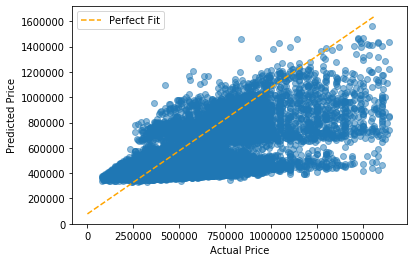

In [190]:
# Baseline model
preds = model_baseline.predict()
fig, ax = plt.subplots()

perfect_line = np.arange(data.price.min(), data.price.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(data.price, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

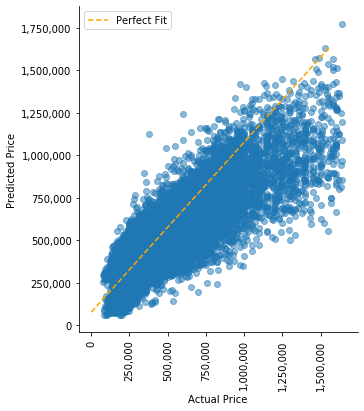

In [191]:
# Selected model: Model 9
fig, ax = plt.subplots(figsize = (5,6))

preds = model_9.predict()

perfect_line = np.arange(data.price.min(), data.price.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(data.price, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

plt.xticks(rotation=90)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
sns.despine()


- Selected model (model 9) has outliers but there is an overall linear relationship. The linearity assumption is not violated.

#### Normality

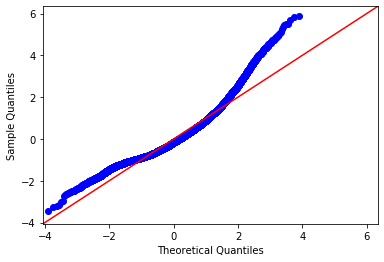

In [192]:
# Test the normality assumption with QQ plot
residuals = model_baseline.resid
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.show()

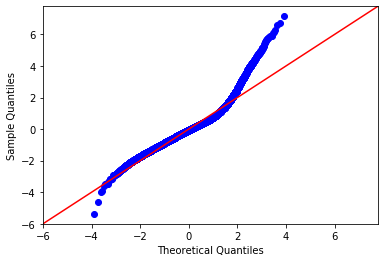

In [193]:
residuals = model_9.resid  
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.show()

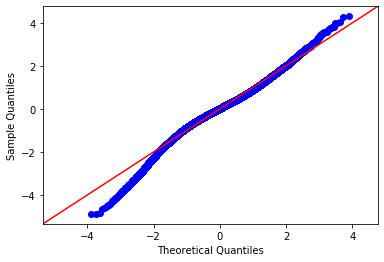

In [194]:
residuals = model_11.resid   #log price and log sqft_above
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.show()

- Outliers are problematic in the baseline and model 9, and look worse in model 9 versus the baseline model in terms of the normality assumption. 
- Including log price and log sqft_above in the model (instead of price and sqft_above) improves the normality assumption. This suggests that model 11 is better than model 9 in regards to the normality assumption.

#### Multicollinearity

In [195]:
# Baseline model
vif = [variance_inflation_factor(X_model_baseline.values, i) for i in range(X_model_baseline.shape[1])]
pd.Series(vif, index=X_model_baseline.columns, name="Variance Inflation Factor")

const         8.400149
sqft_above    1.788615
grade_9       1.357943
grade_10      1.332484
grade_11      1.176777
grade_12      1.031761
Name: Variance Inflation Factor, dtype: float64

In [196]:
# Selected model
vif = [variance_inflation_factor(X_model_9.values, i) for i in range(X_model_9.shape[1])]
pd.Series(vif, index=X_model_9.columns, name="Variance Inflation Factor")

const                  14.542689
sqft_above              3.421760
grade_8                 1.486006
grade_9                 1.856097
grade_10                1.741881
grade_11                1.370202
grade_12                1.076635
bathrooms_1.75          1.158437
bathrooms_2.0           1.085170
bathrooms_2.75          1.105376
bathrooms_3.0           1.076035
bathrooms_3.25          1.117407
bathrooms_3.5           1.195816
bathrooms_3.75          1.059529
bathrooms_4.0           1.062376
bathrooms_4.25          1.049870
levels_two              1.797019
levels_threeplus        1.203440
basement                1.350952
waterfront              1.052594
sqft_lot                1.158561
renovated               1.030854
condition_good          1.168499
condition_very_good     1.098717
city_Auburn             1.086264
city_Bellevue           1.165658
city_Black_Diamond      1.018686
city_Bothell            1.019738
city_Duvall             1.031228
city_Enumclaw           1.054562
city_Fall_

- Low mutlicollinearity in baseline model and selected model 9. Model 11 also has low multicolllinearity.

#### Homoscedasticity

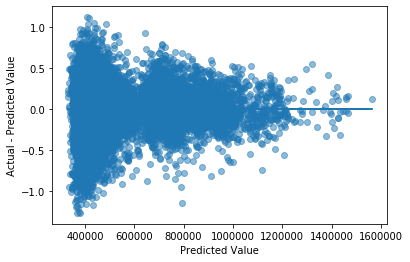

In [197]:
# Baseline model
fig, ax = plt.subplots()

preds = model_baseline.predict()
ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_model_7))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

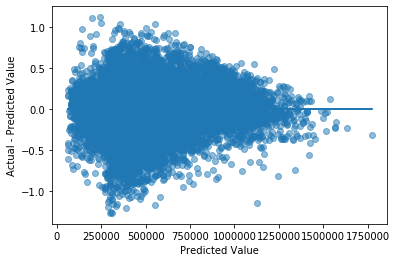

In [198]:
# Selected model: Model 9
fig, ax = plt.subplots()

preds = model_9.predict()
ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_model_7))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

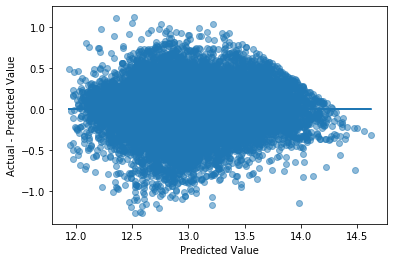

In [199]:
# Selected model: Model 11  #log price and log sqft_above
fig, ax = plt.subplots()

preds = model_11.predict()
ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_model_8))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

- Residuals in selected model 9 (and model 11) are heteroscedastic, varying based on the predicted price. This is a result of how outliers were removed in the preprocessing. Recall that--for price, bedrooms, and bathrooms--maximum thresholds were set at three standard deviations above the mean. Values above these thresholds were dropped.
- Homoskedasticity assumption is violated.